In [67]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import numpy as np
import pandas as pd
import sys
import importlib
import shutil
import math
import os
from pathlib import Path
import warnings

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation


warnings.simplefilter('ignore')

MIN_THRESHOLD = -10000000

%matplotlib inline

# Data Profiling

The model performance is tightly coupled to the data profile. Below are metadata and nodule profiles for LUNA16 and SUMMIT.

(16187, 26)
(5943, 26)


<Figure size 500x2000 with 0 Axes>

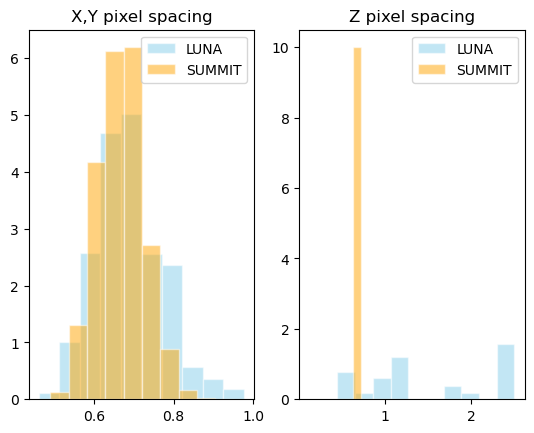

In [68]:
# LUNA metadata
luna_metadata = pd.read_csv('../scans/luna16/metadata/metadata.csv')
luna_metadata[['x_spacing','y_spacing','z_spacing']] = luna_metadata.ElementSpacing.str.strip('[]').str.split(expand=True).astype(float)

lung50_metadata = pd.read_csv('../scans/lung50/lung50_metadata.csv')
lung50_metadata['slices'] = lung50_metadata.slices.astype(float)
lung50_metadata['scan_id'] = lung50_metadata.scan_id.str.strip('.mhd')
lung50_metadata['timepoint'] = lung50_metadata.timepoint.str.strip('.mhd')
veolity_metadata = (
                    pd.read_csv('../scans/lung50/veolity_metadata.csv', usecols=['index','DimSize'])
                    .assign(slices=lambda df: df.DimSize.str.strip('[]').str.split().str[2].astype(float))
                    .assign(scan_id=lambda df: df['index'].str.strip('.mhd').str.split('/').str[-1])
                    .drop(columns=['index','DimSize'])
)

print(lung50_metadata.shape)
lung50_metadata = lung50_metadata.merge(veolity_metadata, left_on=['scan_id','slices'], right_on=['scan_id','slices'])
lung50_metadata = lung50_metadata[lung50_metadata['timepoint']=='Y0_BASELINE_A']
print(lung50_metadata.shape)

fig = plt.figure(figsize=[5,20])
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(luna_metadata.x_spacing, alpha=0.5, color='skyblue', edgecolor='white', label='LUNA', density=True)
ax[0].hist(lung50_metadata['x-spacing'], alpha=0.5, color='orange', edgecolor='white', label='SUMMIT', density=True)
ax[0].set_title('X,Y pixel spacing')
ax[0].legend()

ax[1].hist(luna_metadata.z_spacing, alpha=0.5, color='skyblue', edgecolor='white', label='LUNA', density=True)
ax[1].hist(lung50_metadata['z-spacing'], alpha=0.5, color='orange', edgecolor='white', label='SUMMIT', density=True)
ax[1].set_title('Z pixel spacing')
ax[1].legend()

plt.show()


,1,2,3,4,5,6,7
FPR,0.125,0.25,0.5,1,2,4,8
Liu et al.,0.848,0.876,0.905,0.933,0.943,0.957,0.97
nnDetection,0.812,0.885,0.927,0.95,0.969,0.979,0.985
MONAI-Detection,0.835,0.885,0.931,0.957,0.974,0.983,0.988


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


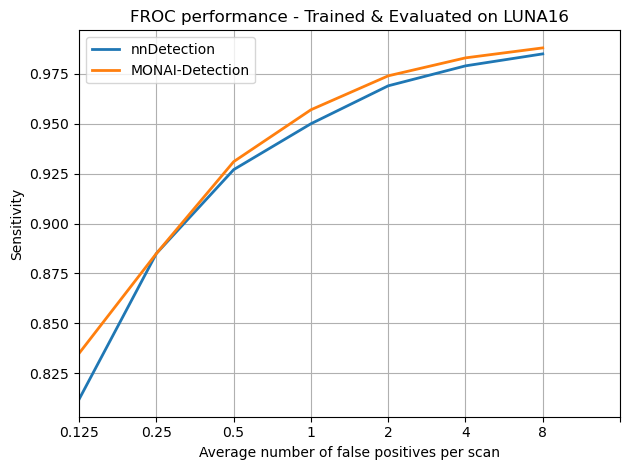

In [69]:
# LUNA16 Results Trained on LUNA16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = [
    row.split('\t')
    for row in """
    Methods	0.125	0.25	0.5	1	2	4	8
    Liu et al. (2019)	0.848	0.876	0.905	0.933	0.943	0.957	0.970
    nnDetection (2021)	0.812	0.885	0.927	0.950	0.969	0.979	0.985
    MONAI detection	0.835	0.885	0.931	0.957	0.974	0.983	0.988
    """.split('\n')
    if row
]
data = pd.DataFrame(data).transpose().drop(0).drop(4, axis=1).rename(columns={0:'FPR',1:'Liu et al.',2:'nnDetection',3:'MONAI-Detection'})
data[['Liu et al.','nnDetection','MONAI-Detection']] = data[['Liu et al.','nnDetection','MONAI-Detection']].astype(float)

display(data.T)
data.T.to_csv('../output/results/models.csv')

def display_froc(fpr_list, recall_list, labels):


    graphTitle = str("")
    fig1 = plt.figure()
    ax = plt.gca()
    


    xmin = 0.125
    xmax = 8

    plt.xlim(0, 7)
    #plt.ylim(0.8, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right')
    plt.title('FROC performance - Trained & Evaluated on LUNA16')
    
    ax.xaxis.set_major_formatter(FixedFormatter([0.125,0.25,0.5,1,2,4,8]))

    for fpr, recall, label in zip(fpr_list, recall_list, labels):
        plt.plot(range(7),fpr , label=label, lw=2)

    # set your ticks manually
    # ax.xaxis.set_ticks(['0.125','0.25','0.5','1','2','4','8'])
    #ax.yaxis.set_ticks(np.arange(0.8, 1.1, 0.1))
    plt.legend()
    plt.grid(visible=True, which='both')
    plt.tight_layout()
    plt.show()



display_froc(
    fpr_list = [
        #np.array(data['Liu et al.']),
        np.array(data['nnDetection']),
        np.array(data['MONAI-Detection'])
        ],
    recall_list=[
        #np.array(data.FPR),
        np.array(data.FPR),
        np.array(data.FPR)
    ],
    labels = [
        #'Liu et al.',
        'nnDetection',
        'MONAI-Detection'
    ])

# GRT123 Evaluation

In [70]:
# General purpose functions for evaluating predictions
"""
    The evaluation script accepts 4 parameters

    1. annotations_filename: csv file with following headers:
        - threshold
        - index
        - row
        - col
        - diameter
        - nodule_type
        - brock_score
        - management_plan
        - ethnic_group

    NOTE: Additional nodule fields will need to be added in eval script, fields are hard-coded
    into a nodule class

    2. annotations_excluded_filename: csv containing non-actionable or benign lesions,
    headers as per annotations_filename

    3. seriesuids_filename: single column csv file holding just the scan identifiers

    4. results_filename: csv containing the candidates generated from the detection algorithm.
    Headers as follows:
        - threshold
        - index
        - row
        - col
        - diameter

    5. outputdir: folder to output results to

"""


FROC_minX = 0.125 # Mininum value of x-axis of FROC curve
FROC_maxX = 128 # Maximum value of x-axis of FROC curve

def create_summary_froc_graph(output_path, limiter, filter_names, filters_fps_itp, filters_sens_itp, x_range=[0.125,0.25,0.5,1,2,4,8,16,32,64,128]):

    graphTitle = str("")
    fig1 = plt.figure()
    ax = plt.gca()
    
    for idx in range(len(filter_names)):
        plt.plot(filters_fps_itp[idx], filters_sens_itp[idx], label="%s" % filter_names[idx], lw=2)

    xmin = FROC_minX
    xmax = FROC_maxX

    plt.xlim(xmin, xmax)
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right')
    plt.title('FROC performance - %s' % (limiter))
    
    plt.xscale('log', base=2)
    ax.xaxis.set_major_formatter(FixedFormatter(x_range))

    # set your ticks manually
    ax.xaxis.set_ticks(x_range)
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    plt.grid(visible=True, which='both')
    plt.tight_layout()

    plt.savefig(os.path.join(output_path, "froc_%s.png" % limiter), bbox_inches=0, dpi=300)

def FROCScores(scan_metadata, nodule_metadata, predictions, output_dir, filter_name, min_diameter, management_plan, ethnicity, gender, age, max):
    # RANDOMISATION_AT_YEAR_1

    results_dir = Path(output_dir, 'results')
    results_dir.mkdir(parents=True, exist_ok=True)

    annotations_filepath            = Path(output_dir, 'nodule_annotations.csv')
    annotations_exclude_filepath    = Path(output_dir, 'nodule_exclude_annotations.csv')
    predictions_filepath            = Path(output_dir, 'predictions.csv')
    scanlist_filepath               = Path(output_dir, 'scanslist.csv')

    scan_metadata = scan_metadata[scan_metadata.ethnic_group.isin(ethnicity)]
    scan_metadata = scan_metadata[scan_metadata.gender.isin(gender)]
    scan_metadata = scan_metadata[scan_metadata.age_group.isin(age)]

    nodule_metadata = nodule_metadata[nodule_metadata.ethnic_group.isin(ethnicity)]
    nodule_metadata = nodule_metadata[nodule_metadata.gender.isin(gender)]
    nodule_metadata = nodule_metadata[nodule_metadata.age_group.isin(age)]

    pd.DataFrame(scan_metadata.groupby(['ethnic_group','gender','age_group']).size()).to_csv(Path(results_dir,'scan_counts.csv'))
    pd.DataFrame(nodule_metadata.groupby(['ethnic_group','gender','age_group']).size()).to_csv(Path(results_dir,'nodule_counts.csv'))

    N = max if max < nodule_metadata.shape[0] else nodule_metadata.shape[0]
    nodule_metadata = nodule_metadata.sample(n=N, random_state=42)

    exclude  = (nodule_metadata.management_plan==management_plan) | (nodule_metadata.diameter<min_diameter)
    include_nodule_data = nodule_metadata[~exclude]
    exclude_nodule_data = nodule_metadata[exclude]
    include_nodule_data.to_csv(annotations_filepath, index=False)
    exclude_nodule_data.to_csv(annotations_exclude_filepath, index=False)
    predictions.to_csv(predictions_filepath, index=False)

    with open(scanlist_filepath, 'w') as f:
        for idx, scan_id in enumerate(scan_metadata.scan_id):
            f.write(scan_id)
            f.write('\n')
    print('Unique Scans:', idx)

    fps_itp, sens_itp = noduleCADEvaluation(annotations_filename=annotations_filepath,
                        annotations_excluded_filename=annotations_exclude_filepath,
                        seriesuids_filename=scanlist_filepath,
                        results_filename=predictions_filepath,
                        outputDir=results_dir,
                        filter=filter_name)
    
    return fps_itp, sens_itp

def miss_check(output_path, all_nodule_data, exclude_filter, save=True, show=True):
    misses = (
                pd.read_csv(Path(output_path, 'results', 'nodulesWithoutCandidate_predictions.txt'), header=None)
                .rename(columns={
                    0:'name',
                    1:'idx',
                    2:'col',
                    3:'row',
                    4:'index',
                    5:'diameter',
                    6:'candidate_idx'}
                )
    )

    all_nodule_data = all_nodule_data[all_nodule_data.management_plan!=exclude_filter]


    nodule_data = pd.read_csv(Path(output_path, 'nodule_annotations.csv'))

    misses = misses.merge(nodule_data, left_on='idx', right_on='id', suffixes=['_miss', ''])

    # Check distribution of type vs base distribution to see if one
    tx1 = (pd.concat([
        misses.ethnic_group.value_counts().rename('misses'),
        (misses.ethnic_group.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.ethnic_group.value_counts().rename('sample'),
        (nodule_data.ethnic_group.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.ethnic_group.value_counts().rename('all'),
        (all_nodule_data.ethnic_group.value_counts(normalize=True).rename('all (%)') * 100).astype(int),        
    ], axis=1).fillna(0))
    tx2 = (pd.concat([
        misses.gender.value_counts().rename('misses'),
        (misses.gender.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.gender.value_counts().rename('sample'),
        (nodule_data.gender.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.gender.value_counts().rename('all'),
        (all_nodule_data.gender.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))
    tx3 = (pd.concat([
        misses.age_group.value_counts().rename('misses'),
        (misses.age_group.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.age_group.value_counts().rename('sample'),
        (nodule_data.age_group.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.age_group.value_counts().rename('all'),
        (all_nodule_data.age_group.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    tx123 = pd.concat([tx1,tx2,tx3])

    # type of nodule is being missed
    t1 = (pd.concat([
        misses.nodule_type.value_counts().rename('misses'),
        (misses.nodule_type.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.nodule_type.value_counts().rename('sample'),
        (nodule_data.nodule_type.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.nodule_type.value_counts().rename('all'),
        (all_nodule_data.nodule_type.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t2 = (pd.concat([
        misses.management_plan.value_counts().rename('misses'),
        (misses.management_plan.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.management_plan.value_counts().rename('sample'),
        (nodule_data.management_plan.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.management_plan.value_counts().rename('all'),
        (all_nodule_data.management_plan.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t3 = (pd.concat([
        misses.nodule_site.value_counts(dropna=False).rename('misses'),
        (misses.nodule_site.value_counts(normalize=True, dropna=False).rename('misses (%)') * 100).astype(int),
        nodule_data.nodule_site.value_counts(dropna=False).rename('sample'),
        (nodule_data.nodule_site.value_counts(normalize=True, dropna=False).rename('sample (%)') * 100).astype(int),
        all_nodule_data.nodule_site.value_counts(dropna=False).rename('all'),
        (all_nodule_data.nodule_site.value_counts(normalize=True, dropna=False).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t123 = pd.concat([t1,t2,t3])

    t4 = (pd.concat([
        misses.diameter.describe().rename('misses (%)'),
        nodule_data.nodule_diameter_mm.describe().rename('sample (%)'),
        all_nodule_data.nodule_diameter_mm.describe().rename('all (%)')
    ], axis=1))

    tables_path = Path(output_path, 'tables')
    tables_path.mkdir(parents=True, exist_ok=True)

    if save:
        tx123.to_csv(Path(tables_path, 'demographic_profile.csv'))
        t123.to_csv(Path(tables_path, 'nodule_profile_1.csv'))
        t4.to_csv(Path(tables_path, 'nodule_profile_2.csv'))

    if show:
        display('Missed nodule profiles')
        display(tx123)
        display(t123)
        display(t4)

    return tx123, t123, t4


## Trained on LUNA16 Evaluted on SUMMIT

In [71]:
## Trained on SUMMIT evaluated in SUMMIT

RESULTS_PATH = '../output/results'
METADATA_PATH = '../output/metadata'
BBOX_RESULTS_PATH = '../models/grt123/bbox_result/trained_luna/'
TRAINING_DATA = 'trained_luna'
MODEL = 'GRT123'
NAME = 'all'
PHASE = 'validation'

predictions = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'predictions.csv'))
nodule_metadata = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'metadata.csv'))

# orrible little hack to include gender and age
md = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/all/validation_metadata.csv', usecols=['participant_id','nodule_lesion_id','gender','age_group'])
nodule_metadata = nodule_metadata.merge(md, left_on=['participant_id','nodule_lesion_id'], right_on=['participant_id','nodule_lesion_id'])

scan_metadata = (
    pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/all/validation_scans_metadata.csv',
                usecols=[
                    'LDCT_RADIOLOGY_REPORT_main_participant_id',
                    'participant_details_gender',
                    'participant_age_at_consent_cats',
                    'mpi_ParticipantMetadata_EthnicCategoryStr'
                ]).rename(columns={
                    'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
                    'participant_details_gender' : 'gender',
                    'participant_age_at_consent_cats' : 'age_group',
                    'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'                    
                })
    .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
)
display(scan_metadata.head())


print('Prediction:{}, Nodules:{}, Scans:{}'.format(
    predictions.shape[0],
    nodule_metadata.shape[0],
    scan_metadata.shape[0]
))

predictions

,participant_id,gender,age_group,ethnic_group,scan_id
0,summit-2224-gak,MALE,65-69,Black,summit-2224-gak_Y0_BASELINE_A
1,summit-2224-jcz,FEMALE,55-59,Black,summit-2224-jcz_Y0_BASELINE_A
2,summit-2224-jgv,FEMALE,65-69,Asian or Asian British,summit-2224-jgv_Y0_BASELINE_A
3,summit-2225-fhj,FEMALE,70-75,White,summit-2225-fhj_Y0_BASELINE_A
4,summit-2225-stn,MALE,60-64,White,summit-2225-stn_Y0_BASELINE_A


Prediction:7445, Nodules:2866, Scans:1783


,threshold,index,row,col,diameter,name
0,-0.370926,61.600450,45.230392,73.265724,9.103833,summit-2224-gak_Y0_BASELINE_A
1,-0.995496,65.643550,77.150085,81.650580,9.781627,summit-2224-gak_Y0_BASELINE_A
2,-0.120166,37.197820,117.504680,21.492664,8.887494,summit-2224-jcz_Y0_BASELINE_A
3,2.502366,257.792450,101.902140,165.922300,9.524376,summit-2224-jgv_Y0_BASELINE_A
4,-0.673333,21.483385,41.150400,48.953083,8.540439,summit-2224-jgv_Y0_BASELINE_A
...,...,...,...,...,...,...
7440,3.068370,105.288670,13.381742,229.877800,9.810271,summit-9987-tkh_Y0_BASELINE_A
7441,0.596810,37.565937,137.156590,13.393623,8.900789,summit-9987-tkh_Y0_BASELINE_A
7442,-0.400254,37.344260,149.323680,17.612043,8.793003,summit-9987-tkh_Y0_BASELINE_A
7443,-0.828278,173.221880,73.209206,165.327030,8.583631,summit-9989-ems_Y0_BASELINE_A


In [72]:
display(nodule_metadata.management_plan.value_counts())
display(
    pd.concat([
        scan_metadata.ethnic_group.value_counts().rename('scans'),
        nodule_metadata.ethnic_group.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.gender.value_counts().rename('scans'),
        nodule_metadata.gender.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.age_group.value_counts().rename('scans'),
        nodule_metadata.age_group.value_counts().rename('nodules')
    ], axis=1)
)

RANDOMISATION_AT_YEAR_1    2004
3_MONTH_FOLLOW_UP_SCAN      661
ALWAYS_SCAN_AT_YEAR_1       134
URGENT_REFERRAL              67
Name: management_plan, dtype: int64

,scans,nodules
White,1311,2264.0
Asian or Asian British,205,299.0
Black,130,172.0
Other ethnic groups,77,74.0
Mixed,31,57.0
Not stated,29,NaN


,scans,nodules
MALE,1075,1696
FEMALE,708,1170


,scans,nodules
60-64,461,664
65-69,448,818
70-75,420,723
55-59,365,502
75+,89,159


In [73]:
# Filters 
filters = {
    'ethnicity' : 
    {
        'filter_WHITE' : {
            'ethnicity' : ['White'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_ASIAN' : {
            'ethnicity' : ['Asian or Asian British'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_BLACK' : {
            'ethnicity' : ['Black'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    },
    'gender' : 
    {
        'filter_MALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['MALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_FEMALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    }
}

Unique Scans: 1753
../output/results/GRT123/trained_luna/all/filterNone_excl/nodule_annotations.csv
Total number of included nodule annotations: 2832
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1498,77,2264,78,2264,78
Asian or Asian British,224,11,299,10,299,10
Black,124,6,172,6,172,6
Other ethnic groups,54,2,74,2,74,2
Mixed,39,2,57,1,57,1
MALE,1136,58,1696,59,1696,59
FEMALE,803,41,1170,40,1170,40
65-69,542,27,818,28,818,28
70-75,479,24,723,25,723,25
60-64,461,23,664,23,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,905,46,1211,42,1211,42
SOLID,763,39,1200,41,1200,41
CALCIFIED,112,5,179,6,179,6
NON_SOLID,95,4,145,5,145,5
PART_SOLID,45,2,107,3,107,3
ENDOBRONCHIAL,19,0,24,0,24,0
RANDOMISATION_AT_YEAR_1,1574,81,2004,69,2004,69
3_MONTH_FOLLOW_UP_SCAN,273,14,661,23,661,23
ALWAYS_SCAN_AT_YEAR_1,84,4,134,4,134,4
URGENT_REFERRAL,8,0,67,2,67,2


,misses (%),sample (%),all (%)
count,1939.000000,2866.000000,2866.000000
mean,3.919797,7.174110,7.174110
std,2.501985,4.579834,4.579834
min,0.000000,0.000000,0.000000
25%,2.653516,4.500000,4.500000
50%,3.369140,6.000000,6.000000
75%,4.374806,8.200000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 1753
../output/results/GRT123/trained_luna/all/filterNone_exclRANDOMISATION_AT_YEAR_1/nodule_annotations.csv
Total number of included nodule annotations: 847
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,297,81,710,82,710,82
Asian or Asian British,35,9,73,8,73,8
Black,17,4,40,4,40,4
Other ethnic groups,9,2,17,1,17,1
Mixed,7,1,22,2,22,2
MALE,190,52,454,52,454,52
FEMALE,175,47,408,47,408,47
65-69,108,29,254,29,254,29
70-75,88,24,229,26,229,26
60-64,85,23,188,21,188,21


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,112,30,179,20,179,20
SOLID,105,28,418,48,418,48
NON_SOLID,84,23,134,15,134,15
PART_SOLID,45,12,107,12,107,12
ENDOBRONCHIAL,19,5,24,2,24,2
3_MONTH_FOLLOW_UP_SCAN,273,74,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,84,23,134,15,134,15
URGENT_REFERRAL,8,2,67,7,67,7
RIGHT_UPPER_LOBE,119,32,280,32,280,32
LEFT_UPPER_LOBE,86,23,173,20,173,20


,misses (%),sample (%),all (%)
count,365.000000,862.000000,862.000000
mean,6.419174,11.030278,11.030278
std,4.428936,6.261209,6.261209
min,0.000000,0.000000,0.000000
25%,3.951955,7.400000,7.400000
50%,5.242385,9.050000,9.050000
75%,7.846099,13.100000,13.100000
max,29.139242,41.100000,41.100000


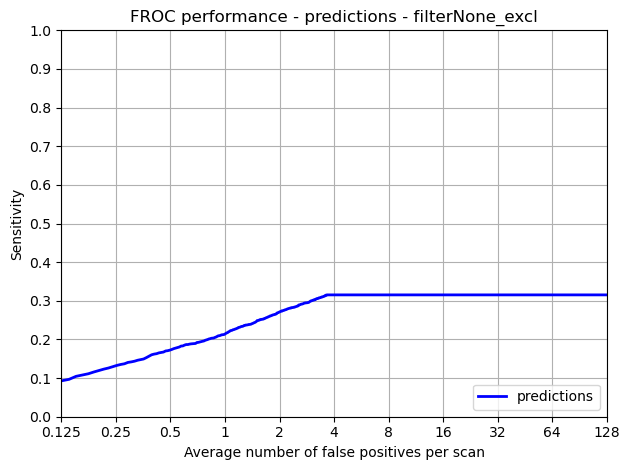

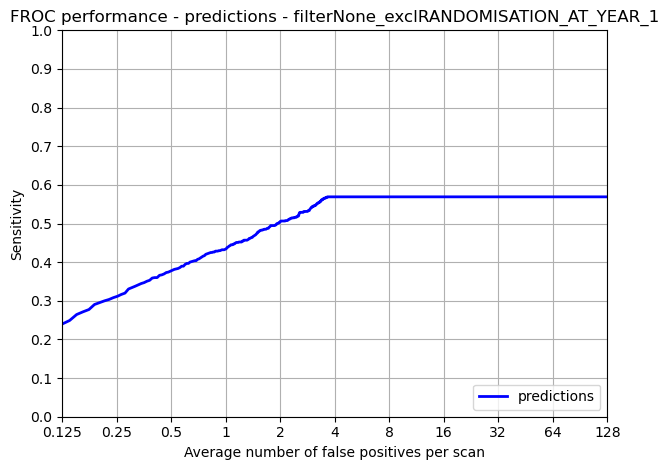

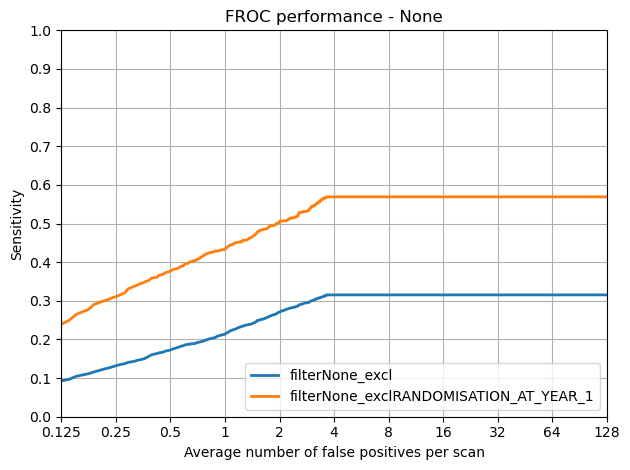

In [74]:
# What is the overall FROC Score

filter_names = []
filters_fps_itp = []
filters_sens_itp = []

for management_plan in ['', 'RANDOMISATION_AT_YEAR_1']:

    filter_name = 'filterNone_excl'+management_plan
    filter_names.append(filter_name)

    output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
    output_dir.mkdir(parents=True, exist_ok=True)

    fps_itp, sens_itp = FROCScores(scan_metadata,
        nodule_metadata,
        predictions,
        output_dir,
        filter_name,
        0,
        management_plan,
        ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
        ['MALE','FEMALE'],
        ['55-59', '60-64', '65-69', '70-75', '75+'],
        10000)
    
    _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)
    
    filters_fps_itp.append(fps_itp)
    filters_sens_itp.append(sens_itp)


create_summary_froc_graph(
    Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME),
    None,
    filter_names,
    filters_fps_itp,
    filters_sens_itp
)

## Trained on SUMMIT Evaluated on SUMMIT

In [75]:


RESULTS_PATH = '../output/results'
METADATA_PATH = '../output/metadata'
BBOX_RESULTS_PATH = '../models/grt123/bbox_result/trained_summit/'
TRAINING_DATA = 'trained_summit'
MODEL = 'GRT123'
NAME = 'all'
PHASE = 'validation'

predictions = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'predictions.csv'))
nodule_metadata = pd.read_csv(Path(BBOX_RESULTS_PATH, NAME, 'metadata.csv'))

# orrible little hack to include gender and age
md = pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/all/validation_metadata.csv', usecols=['participant_id','nodule_lesion_id','gender','age_group'])
nodule_metadata = nodule_metadata.merge(md, left_on=['participant_id','nodule_lesion_id'], right_on=['participant_id','nodule_lesion_id'])

scan_metadata = (
    pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/all/validation_scans_metadata.csv',
                usecols=[
                    'LDCT_RADIOLOGY_REPORT_main_participant_id',
                    'participant_details_gender',
                    'participant_age_at_consent_cats',
                    'mpi_ParticipantMetadata_EthnicCategoryStr'
                ]).rename(columns={
                    'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
                    'participant_details_gender' : 'gender',
                    'participant_age_at_consent_cats' : 'age_group',
                    'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'                    
                })
    .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
)
display(scan_metadata.head())


print('Prediction:{}, Nodules:{}, Scans:{}'.format(
    predictions.shape[0],
    nodule_metadata.shape[0],
    scan_metadata.shape[0]
))

FileNotFoundError: [Errno 2] No such file or directory: '../models/grt123/bbox_result/all/predictions.csv'

In [ ]:
display(nodule_metadata.management_plan.value_counts())
display(
    pd.concat([
        scan_metadata.ethnic_group.value_counts().rename('scans'),
        nodule_metadata.ethnic_group.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.gender.value_counts().rename('scans'),
        nodule_metadata.gender.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.age_group.value_counts().rename('scans'),
        nodule_metadata.age_group.value_counts().rename('nodules')
    ], axis=1)
)

RANDOMISATION_AT_YEAR_1    2004
3_MONTH_FOLLOW_UP_SCAN      661
ALWAYS_SCAN_AT_YEAR_1       134
URGENT_REFERRAL              67
Name: management_plan, dtype: int64

,scans,nodules
White,1311,2264.0
Asian or Asian British,205,299.0
Black,130,172.0
Other ethnic groups,77,74.0
Mixed,31,57.0
Not stated,29,NaN


,scans,nodules
MALE,1075,1696
FEMALE,708,1170


,scans,nodules
60-64,461,664
65-69,448,818
70-75,420,723
55-59,365,502
75+,89,159


In [ ]:
# Filters 
filters = {
    'ethnicity' : 
    {
        'filter_WHITE' : {
            'ethnicity' : ['White'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_ASIAN' : {
            'ethnicity' : ['Asian or Asian British'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_BLACK' : {
            'ethnicity' : ['Black'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    },
    'gender' : 
    {
        'filter_MALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['MALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_FEMALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    }
}

Unique Scans: 1753
../output/results/GRT123/trained_summit/all/filterNone_excl/nodule_annotations.csv
Total number of included nodule annotations: 2832
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1020,76,2264,78,2264,78
Asian or Asian British,155,11,299,10,299,10
Black,89,6,172,6,172,6
Other ethnic groups,40,3,74,2,74,2
Mixed,27,2,57,1,57,1
MALE,745,55,1696,59,1696,59
FEMALE,586,44,1170,40,1170,40
65-69,372,27,818,28,818,28
70-75,330,24,723,25,723,25
60-64,320,24,664,23,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,601,45,1211,42,1211,42
SOLID,559,41,1200,41,1200,41
CALCIFIED,86,6,179,6,179,6
NON_SOLID,52,3,145,5,145,5
ENDOBRONCHIAL,18,1,24,0,24,0
PART_SOLID,15,1,107,3,107,3
RANDOMISATION_AT_YEAR_1,1133,85,2004,69,2004,69
3_MONTH_FOLLOW_UP_SCAN,156,11,661,23,661,23
ALWAYS_SCAN_AT_YEAR_1,41,3,134,4,134,4
URGENT_REFERRAL,1,0,67,2,67,2


,misses (%),sample (%),all (%)
count,1331.000000,2866.000000,2866.000000
mean,3.256559,7.174110,7.174110
std,1.766406,4.579834,4.579834
min,0.000000,0.000000,0.000000
25%,2.451268,4.500000,4.500000
50%,2.981444,6.000000,6.000000
75%,3.644141,8.200000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 1753
../output/results/GRT123/trained_summit/all/filterNone_exclRANDOMISATION_AT_YEAR_1/nodule_annotations.csv
Total number of included nodule annotations: 847
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,164,82,710,82,710,82
Asian or Asian British,16,8,73,8,73,8
Black,10,5,40,4,40,4
Other ethnic groups,7,3,17,1,17,1
Mixed,1,0,22,2,22,2
FEMALE,106,53,408,47,408,47
MALE,92,46,454,52,454,52
65-69,66,33,254,29,254,29
70-75,49,24,229,26,229,26
60-64,41,20,188,21,188,21


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,86,43,179,20,179,20
NON_SOLID,41,20,134,15,134,15
SOLID,38,19,418,48,418,48
ENDOBRONCHIAL,18,9,24,2,24,2
PART_SOLID,15,7,107,12,107,12
3_MONTH_FOLLOW_UP_SCAN,156,78,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,41,20,134,15,134,15
URGENT_REFERRAL,1,0,67,7,67,7
RIGHT_UPPER_LOBE,55,27,280,32,280,32
LEFT_UPPER_LOBE,43,21,173,20,173,20


,misses (%),sample (%),all (%)
count,198.000000,862.000000,862.000000
mean,4.843007,11.030278,11.030278
std,3.682084,6.261209,6.261209
min,0.000000,0.000000,0.000000
25%,2.908984,7.400000,7.400000
50%,4.366017,9.050000,9.050000
75%,5.647367,13.100000,13.100000
max,29.139242,41.100000,41.100000


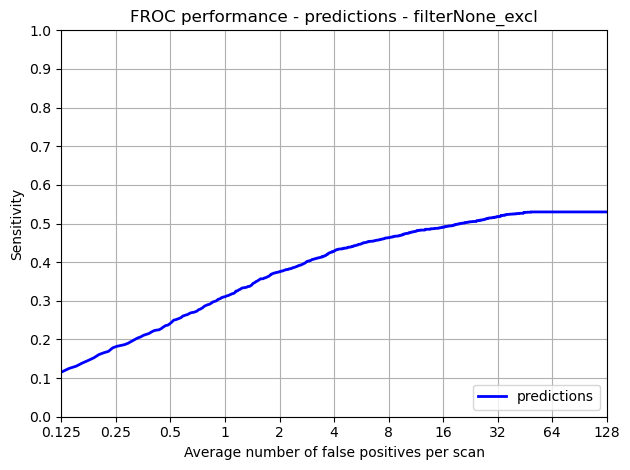

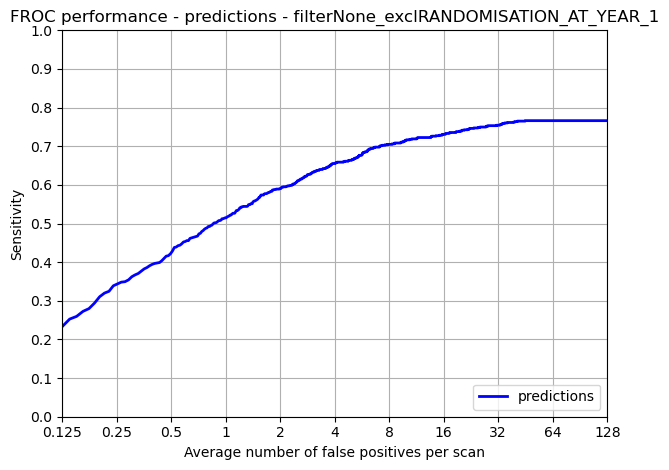

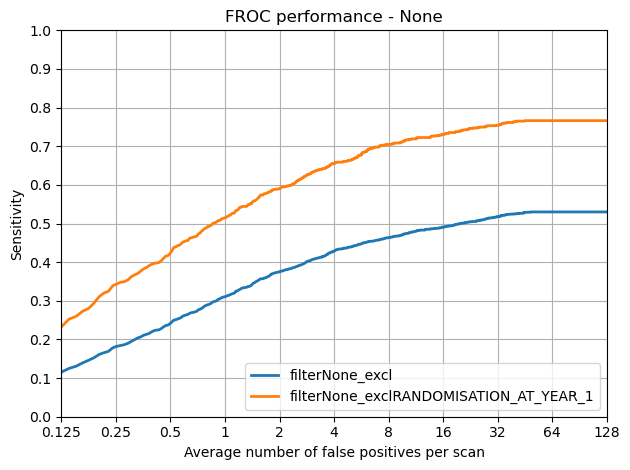

In [ ]:
# What is the overall FROC Score

filter_names = []
filters_fps_itp = []
filters_sens_itp = []

for management_plan in ['','RANDOMISATION_AT_YEAR_1']:

    filter_name = 'filterNone_excl'+management_plan
    filter_names.append(filter_name)

    output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
    output_dir.mkdir(parents=True, exist_ok=True)

    fps_itp, sens_itp = FROCScores(scan_metadata,
        nodule_metadata,
        predictions,
        output_dir,
        filter_name,
        0,
        management_plan,
        ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
        ['MALE','FEMALE'],
        ['55-59', '60-64', '65-69', '70-75', '75+'],
        10000)
    
    _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)
    
    filters_fps_itp.append(fps_itp)
    filters_sens_itp.append(sens_itp)


create_summary_froc_graph(
    Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME),
    None,
    filter_names,
    filters_fps_itp,
    filters_sens_itp
)


Unique Scans: 1310
../output/results/GRT123/trained_summit/all/filter_WHITE_excl_min0/nodule_annotations.csv
Total number of included nodule annotations: 2118
Total number of nodule annotations: 2118
Cases: 1311


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,974.0,100.0,2264.0,100.0,2264,78
Asian or Asian British,0.0,0.0,0.0,0.0,299,10
Black,0.0,0.0,0.0,0.0,172,6
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
MALE,498.0,51.0,1256.0,55.0,1696,59
FEMALE,476.0,48.0,1008.0,44.0,1170,40
65-69,287.0,29.0,639.0,28.0,818,28
70-75,271.0,27.0,641.0,28.0,723,25
60-64,224.0,22.0,509.0,22.0,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,447.0,45.0,958,42,1211,42
SOLID,392.0,40.0,927,40,1200,41
CALCIFIED,75.0,7.0,153,6,179,6
NON_SOLID,35.0,3.0,109,4,145,5
ENDOBRONCHIAL,16.0,1.0,22,0,24,0
PART_SOLID,9.0,0.0,95,4,107,3
RANDOMISATION_AT_YEAR_1,812.0,83.0,1554,68,2004,69
3_MONTH_FOLLOW_UP_SCAN,131.0,13.0,555,24,661,23
ALWAYS_SCAN_AT_YEAR_1,31.0,3.0,105,4,134,4
URGENT_REFERRAL,0.0,0.0,50,2,67,2


,misses (%),sample (%),all (%)
count,974.000000,2264.000000,2866.000000
mean,3.311551,7.288207,7.174110
std,1.883228,4.671423,4.579834
min,0.000000,0.000000,0.000000
25%,2.464746,4.600000,4.500000
50%,3.007812,6.100000,6.000000
75%,3.703709,8.400000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 204
../output/results/GRT123/trained_summit/all/filter_ASIAN_excl_min0/nodule_annotations.csv
Total number of included nodule annotations: 242
Total number of nodule annotations: 242
Cases: 205


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Asian or Asian British,132.0,100.0,299.0,100.0,299,10
White,0.0,0.0,0.0,0.0,2264,78
Black,0.0,0.0,0.0,0.0,172,6
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
MALE,124.0,93.0,275.0,91.0,1696,59
FEMALE,8.0,6.0,24.0,8.0,1170,40
55-59,58.0,43.0,104.0,34.0,502,17
60-64,25.0,18.0,62.0,20.0,664,23
70-75,22.0,16.0,41.0,13.0,723,25


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,66,50,157,52,1200,41
PERIFISSURAL,53,40,111,37,1211,42
NON_SOLID,5,3,15,5,145,5
CALCIFIED,4,3,9,3,179,6
PART_SOLID,3,2,6,2,107,3
ENDOBRONCHIAL,1,0,1,0,24,0
RANDOMISATION_AT_YEAR_1,117,88,226,75,2004,69
3_MONTH_FOLLOW_UP_SCAN,10,7,50,16,661,23
ALWAYS_SCAN_AT_YEAR_1,4,3,13,4,134,4
URGENT_REFERRAL,1,0,10,3,67,2


,misses (%),sample (%),all (%)
count,132.000000,299.000000,2866.000000
mean,3.098686,6.795987,7.174110
std,1.399265,4.341873,4.579834
min,0.000000,0.000000,0.000000
25%,2.476464,4.400000,4.500000
50%,2.848437,5.500000,6.000000
75%,3.448828,7.600000,8.200000
max,11.588678,28.200000,41.100000


Unique Scans: 129
../output/results/GRT123/trained_summit/all/filter_BLACK_excl_min0/nodule_annotations.csv
Total number of included nodule annotations: 136
Total number of nodule annotations: 136
Cases: 130


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Black,77.0,100.0,172.0,100.0,172,6
White,0.0,0.0,0.0,0.0,2264,78
Asian or Asian British,0.0,0.0,0.0,0.0,299,10
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
MALE,42.0,54.0,81.0,47.0,1696,59
FEMALE,35.0,45.0,91.0,52.0,1170,40
65-69,24.0,31.0,54.0,31.0,818,28
55-59,23.0,29.0,39.0,22.0,502,17
60-64,17.0,22.0,51.0,29.0,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,47.0,61.0,91.0,52.0,1211,42
SOLID,24.0,31.0,63.0,36.0,1200,41
CALCIFIED,3.0,3.0,10.0,5.0,179,6
NON_SOLID,2.0,2.0,6.0,3.0,145,5
PART_SOLID,1.0,1.0,2.0,1.0,107,3
ENDOBRONCHIAL,0.0,0.0,0.0,0.0,24,0
RANDOMISATION_AT_YEAR_1,70.0,90.0,132.0,76.0,2004,69
3_MONTH_FOLLOW_UP_SCAN,5.0,6.0,29.0,16.0,661,23
ALWAYS_SCAN_AT_YEAR_1,2.0,2.0,6.0,3.0,134,4
URGENT_REFERRAL,0.0,0.0,5.0,2.0,67,2


,misses (%),sample (%),all (%)
count,77.000000,172.000000,2866.000000
mean,3.053676,6.444186,7.174110
std,1.111437,3.248845,4.579834
min,0.000000,0.000000,0.000000
25%,2.549806,4.300000,4.500000
50%,2.863869,5.500000,6.000000
75%,3.364454,7.600000,8.200000
max,7.930080,20.000000,41.100000


Unique Scans: 1059
../output/results/GRT123/trained_summit/all/filter_MALE_excl_min0/nodule_annotations.csv
Total number of included nodule annotations: 1677
Total number of nodule annotations: 1677
Cases: 1060


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,520.0,69.0,1256.0,74.0,2264,78
Asian or Asian British,144.0,19.0,275.0,16.0,299,10
Black,45.0,6.0,81.0,4.0,172,6
Other ethnic groups,28.0,3.0,57.0,3.0,74,2
Mixed,8.0,1.0,27.0,1.0,57,1
MALE,745.0,100.0,1696.0,100.0,1696,59
FEMALE,0.0,0.0,0.0,0.0,1170,40
65-69,218.0,29.0,518.0,30.0,818,28
70-75,186.0,24.0,455.0,26.0,723,25
55-59,159.0,21.0,334.0,19.0,502,17


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,347,46,763,44,1211,42
SOLID,326,43,729,42,1200,41
CALCIFIED,37,4,78,4,179,6
NON_SOLID,21,2,65,3,145,5
ENDOBRONCHIAL,8,1,9,0,24,0
PART_SOLID,6,0,52,3,107,3
RANDOMISATION_AT_YEAR_1,653,87,1242,73,2004,69
3_MONTH_FOLLOW_UP_SCAN,73,9,358,21,661,23
ALWAYS_SCAN_AT_YEAR_1,18,2,62,3,134,4
URGENT_REFERRAL,1,0,34,2,67,2


,misses (%),sample (%),all (%)
count,745.000000,1696.000000,2866.000000
mean,3.385610,7.136085,7.174110
std,1.858743,4.514977,4.579834
min,0.000000,0.000000,0.000000
25%,2.531250,4.500000,4.500000
50%,3.093750,6.000000,6.000000
75%,3.729493,8.100000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 693
../output/results/GRT123/trained_summit/all/filter_FEMALE_excl_min0/nodule_annotations.csv
Total number of included nodule annotations: 1155
Total number of nodule annotations: 1155
Cases: 694


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,500.0,85.0,1008.0,86.0,2264,78
Black,44.0,7.0,91.0,7.0,172,6
Mixed,19.0,3.0,30.0,2.0,57,1
Other ethnic groups,12.0,2.0,17.0,1.0,74,2
Asian or Asian British,11.0,1.0,24.0,2.0,299,10
FEMALE,586.0,100.0,1170.0,100.0,1170,40
MALE,0.0,0.0,0.0,0.0,1696,59
60-64,169.0,28.0,364.0,31.0,664,23
65-69,154.0,26.0,300.0,25.0,818,28
70-75,144.0,24.0,268.0,22.0,723,25


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,254.0,43.0,448,38,1211,42
SOLID,233.0,39.0,471,40,1200,41
CALCIFIED,49.0,8.0,101,8,179,6
NON_SOLID,31.0,5.0,80,6,145,5
ENDOBRONCHIAL,10.0,1.0,15,1,24,0
PART_SOLID,9.0,1.0,55,4,107,3
RANDOMISATION_AT_YEAR_1,480.0,81.0,762,65,2004,69
3_MONTH_FOLLOW_UP_SCAN,83.0,14.0,303,25,661,23
ALWAYS_SCAN_AT_YEAR_1,23.0,3.0,72,6,134,4
URGENT_REFERRAL,0.0,0.0,33,2,67,2


,misses (%),sample (%),all (%)
count,586.000000,1170.000000,2866.000000
mean,3.092493,7.229231,7.174110
std,1.628384,4.673645,4.579834
min,0.000000,0.000000,0.000000
25%,2.345509,4.500000,4.500000
50%,2.859376,6.000000,6.000000
75%,3.575977,8.300000,8.200000
max,20.614079,36.700000,41.100000


Unique Scans: 1310
../output/results/GRT123/trained_summit/all/filter_WHITE_exclRANDOMISATION_AT_YEAR_1_min0/nodule_annotations.csv
Total number of included nodule annotations: 653
Total number of nodule annotations: 2118
Cases: 1311


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,162.0,100.0,710.0,100.0,710,82
Asian or Asian British,0.0,0.0,0.0,0.0,73,8
Black,0.0,0.0,0.0,0.0,40,4
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
FEMALE,92.0,56.0,367.0,51.0,408,47
MALE,70.0,43.0,343.0,48.0,454,52
65-69,59.0,36.0,204.0,28.0,254,29
70-75,44.0,27.0,209.0,29.0,229,26
60-64,31.0,19.0,151.0,21.0,188,21


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,75.0,46.0,153,21,179,20
NON_SOLID,31.0,19.0,105,14,134,15
SOLID,31.0,19.0,335,47,418,48
ENDOBRONCHIAL,16.0,9.0,22,3,24,2
PART_SOLID,9.0,5.0,95,13,107,12
3_MONTH_FOLLOW_UP_SCAN,131.0,80.0,555,78,661,76
ALWAYS_SCAN_AT_YEAR_1,31.0,19.0,105,14,134,15
URGENT_REFERRAL,0.0,0.0,50,7,67,7
RIGHT_UPPER_LOBE,42.0,25.0,233,32,280,32
RIGHT_LOWER_LOBE,35.0,21.0,129,18,158,18


,misses (%),sample (%),all (%)
count,162.000000,710.000000,862.000000
mean,4.872556,11.025915,11.030278
std,3.799584,6.326986,6.261209
min,0.000000,0.000000,0.000000
25%,2.908984,7.300000,7.400000
50%,4.360351,9.100000,9.050000
75%,5.647367,12.900000,13.100000
max,29.139242,41.100000,41.100000


Unique Scans: 204
../output/results/GRT123/trained_summit/all/filter_ASIAN_exclRANDOMISATION_AT_YEAR_1_min0/nodule_annotations.csv
Total number of included nodule annotations: 60
Total number of nodule annotations: 242
Cases: 205


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Asian or Asian British,15.0,100.0,73.0,100.0,73,8
White,0.0,0.0,0.0,0.0,710,82
Black,0.0,0.0,0.0,0.0,40,4
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
MALE,12.0,80.0,67.0,91.0,454,52
FEMALE,3.0,20.0,6.0,8.0,408,47
75+,4.0,26.0,6.0,8.0,66,7
55-59,3.0,20.0,18.0,24.0,125,14
65-69,3.0,20.0,25.0,34.0,254,29


,misses,misses (%),sample,sample (%),all,all (%)
NON_SOLID,4,26,13,17,134,15
CALCIFIED,4,26,9,12,179,20
SOLID,3,20,44,60,418,48
PART_SOLID,3,20,6,8,107,12
ENDOBRONCHIAL,1,6,1,1,24,2
3_MONTH_FOLLOW_UP_SCAN,10,66,50,68,661,76
ALWAYS_SCAN_AT_YEAR_1,4,26,13,17,134,15
URGENT_REFERRAL,1,6,10,13,67,7
RIGHT_UPPER_LOBE,5,33,26,35,280,32
NOT_ANSWERED,3,20,6,8,84,9


,misses (%),sample (%),all (%)
count,15.000000,73.000000,862.000000
mean,4.762058,11.420548,11.030278
std,3.178644,6.348796,6.261209
min,0.000000,0.000000,0.000000
25%,3.189162,7.500000,7.400000
50%,4.763673,9.000000,9.050000
75%,5.216994,13.200000,13.100000
max,11.588678,28.200000,41.100000


Unique Scans: 129
../output/results/GRT123/trained_summit/all/filter_BLACK_exclRANDOMISATION_AT_YEAR_1_min0/nodule_annotations.csv
Total number of included nodule annotations: 26
Total number of nodule annotations: 136
Cases: 130


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Black,7.0,100.0,40.0,100.0,40,4
White,0.0,0.0,0.0,0.0,710,82
Asian or Asian British,0.0,0.0,0.0,0.0,73,8
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
MALE,4.0,57.0,20.0,50.0,454,52
FEMALE,3.0,42.0,20.0,50.0,408,47
60-64,3.0,42.0,12.0,30.0,188,21
55-59,2.0,28.0,12.0,30.0,125,14
75+,1.0,14.0,4.0,10.0,66,7


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,3.0,42.0,10.0,25.0,179,20
NON_SOLID,2.0,28.0,6.0,15.0,134,15
PART_SOLID,1.0,14.0,2.0,5.0,107,12
SOLID,1.0,14.0,22.0,55.0,418,48
ENDOBRONCHIAL,0.0,0.0,0.0,0.0,24,2
3_MONTH_FOLLOW_UP_SCAN,5.0,71.0,29.0,72.0,661,76
ALWAYS_SCAN_AT_YEAR_1,2.0,28.0,6.0,15.0,134,15
URGENT_REFERRAL,0.0,0.0,5.0,12.0,67,7
LEFT_UPPER_LOBE,4.0,57.0,8.0,20.0,173,20
RIGHT_UPPER_LOBE,3.0,42.0,10.0,25.0,280,32


,misses (%),sample (%),all (%)
count,7.000000,40.000000,862.000000
mean,4.189427,10.162500,11.030278
std,2.344285,4.299653,6.261209
min,0.000000,0.000000,0.000000
25%,3.734864,7.600000,7.400000
50%,4.258597,8.900000,9.050000
75%,4.833791,12.500000,13.100000
max,7.930080,20.000000,41.100000


Unique Scans: 1059
../output/results/GRT123/trained_summit/all/filter_MALE_exclRANDOMISATION_AT_YEAR_1_min0/nodule_annotations.csv
Total number of included nodule annotations: 446
Total number of nodule annotations: 1677
Cases: 1060


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,70.0,76.0,343.0,75.0,710,82
Asian or Asian British,13.0,14.0,67.0,14.0,73,8
Black,6.0,6.0,20.0,4.0,40,4
Other ethnic groups,3.0,3.0,11.0,2.0,17,1
Mixed,0.0,0.0,13.0,2.0,22,2
MALE,92.0,100.0,454.0,100.0,454,52
FEMALE,0.0,0.0,0.0,0.0,408,47
70-75,31.0,33.0,141.0,31.0,229,26
65-69,28.0,30.0,136.0,29.0,254,29
55-59,15.0,16.0,80.0,17.0,125,14


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,37,40,78,17,179,20
SOLID,23,25,253,55,418,48
NON_SOLID,18,19,62,13,134,15
ENDOBRONCHIAL,8,8,9,1,24,2
PART_SOLID,6,6,52,11,107,12
3_MONTH_FOLLOW_UP_SCAN,73,79,358,78,661,76
ALWAYS_SCAN_AT_YEAR_1,18,19,62,13,134,15
URGENT_REFERRAL,1,1,34,7,67,7
RIGHT_UPPER_LOBE,22,23,140,30,280,32
RIGHT_LOWER_LOBE,21,22,87,19,158,18


,misses (%),sample (%),all (%)
count,92.000000,454.000000,862.000000
mean,5.653155,11.290969,11.030278
std,4.084253,6.384576,6.261209
min,0.000000,0.000000,0.000000
25%,3.497315,7.400000,7.400000
50%,4.825779,9.100000,9.050000
75%,6.588816,13.000000,13.100000
max,29.139242,41.100000,41.100000


Unique Scans: 693
../output/results/GRT123/trained_summit/all/filter_FEMALE_exclRANDOMISATION_AT_YEAR_1_min0/nodule_annotations.csv
Total number of included nodule annotations: 401
Total number of nodule annotations: 1155
Cases: 694


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,94.0,88.0,367.0,89.0,710,82
Black,4.0,3.0,20.0,4.0,40,4
Other ethnic groups,4.0,3.0,6.0,1.0,17,1
Asian or Asian British,3.0,2.0,6.0,1.0,73,8
Mixed,1.0,0.0,9.0,2.0,22,2
FEMALE,106.0,100.0,408.0,100.0,408,47
MALE,0.0,0.0,0.0,0.0,454,52
65-69,38.0,35.0,118.0,28.0,254,29
60-64,30.0,28.0,118.0,28.0,188,21
70-75,18.0,16.0,88.0,21.0,229,26


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,49.0,46.0,101,24,179,20
NON_SOLID,23.0,21.0,72,17,134,15
SOLID,15.0,14.0,165,40,418,48
ENDOBRONCHIAL,10.0,9.0,15,3,24,2
PART_SOLID,9.0,8.0,55,13,107,12
3_MONTH_FOLLOW_UP_SCAN,83.0,78.0,303,74,661,76
ALWAYS_SCAN_AT_YEAR_1,23.0,21.0,72,17,134,15
URGENT_REFERRAL,0.0,0.0,33,8,67,7
RIGHT_UPPER_LOBE,33.0,31.0,140,34,280,32
LEFT_UPPER_LOBE,29.0,27.0,84,20,173,20


,misses (%),sample (%),all (%)
count,106.000000,408.000000,862.000000
mean,4.139860,10.740196,11.030278
std,3.147337,6.115759,6.261209
min,0.000000,0.000000,0.000000
25%,2.412355,7.300000,7.400000
50%,3.992677,9.000000,9.050000
75%,4.932423,13.125000,13.100000
max,20.614079,36.700000,41.100000


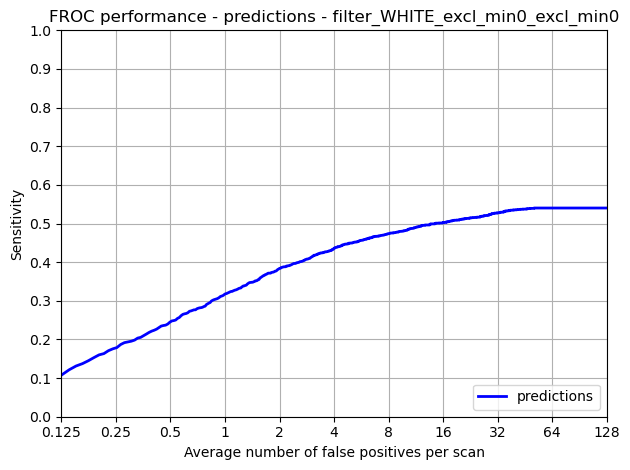

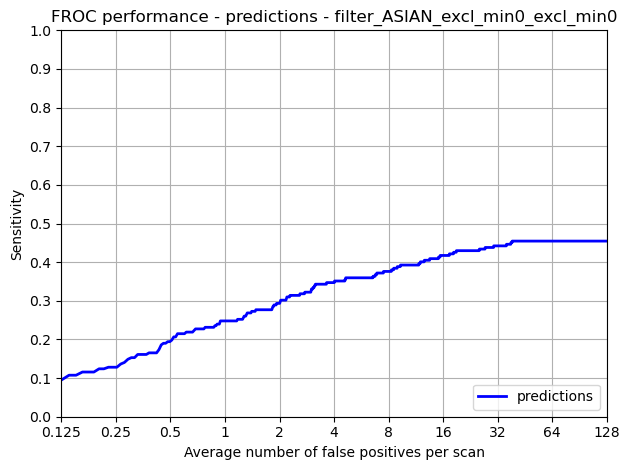

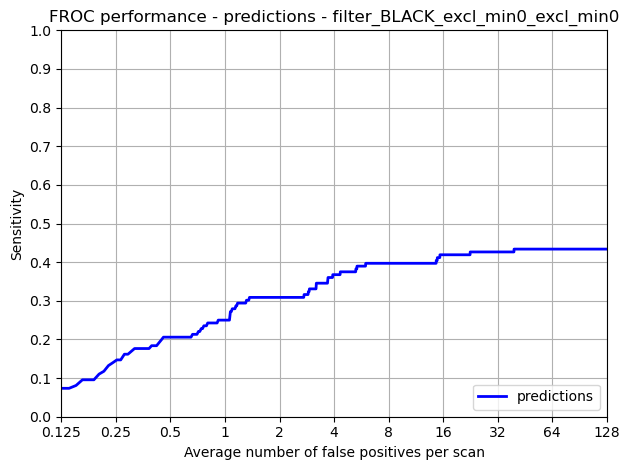

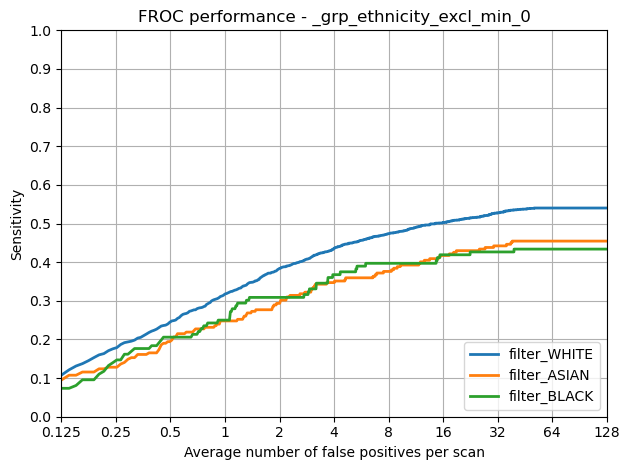

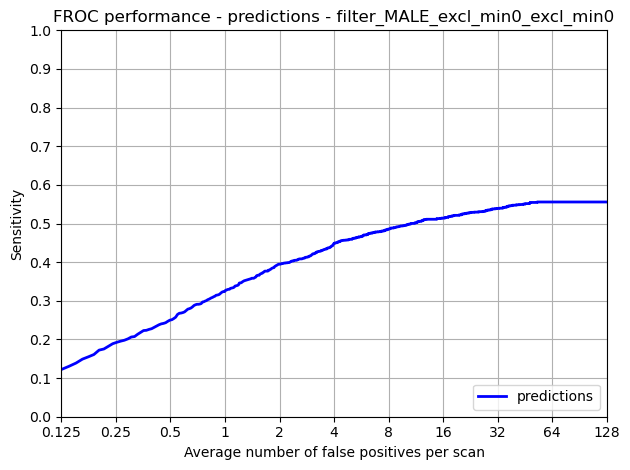

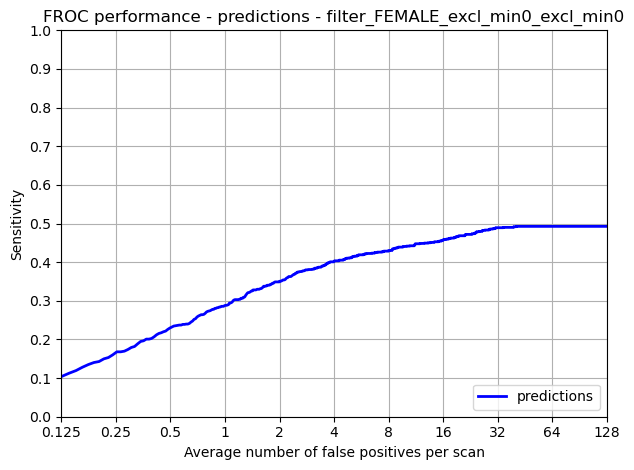

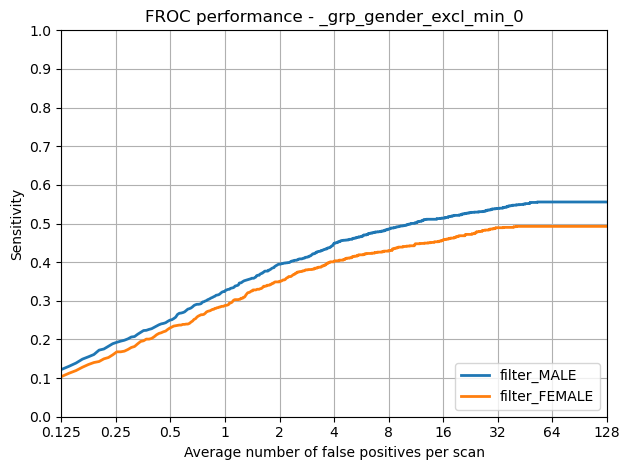

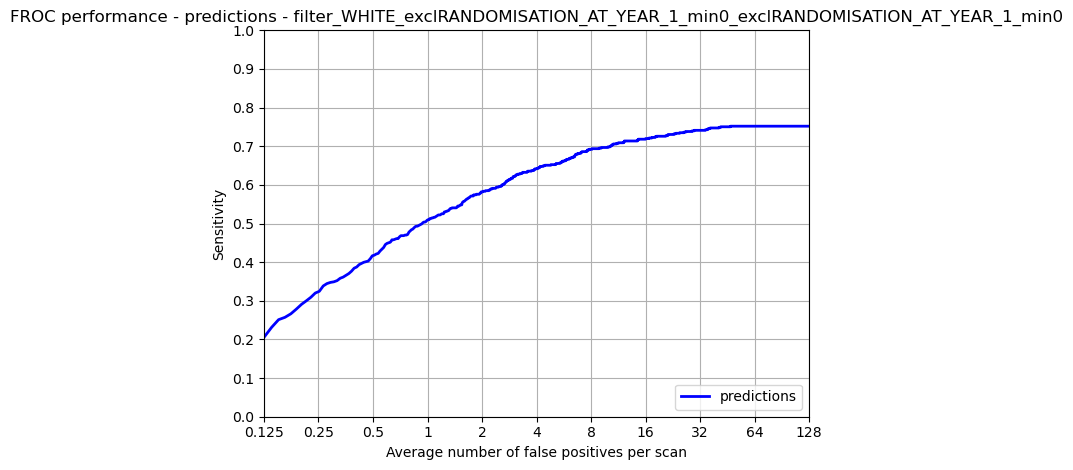

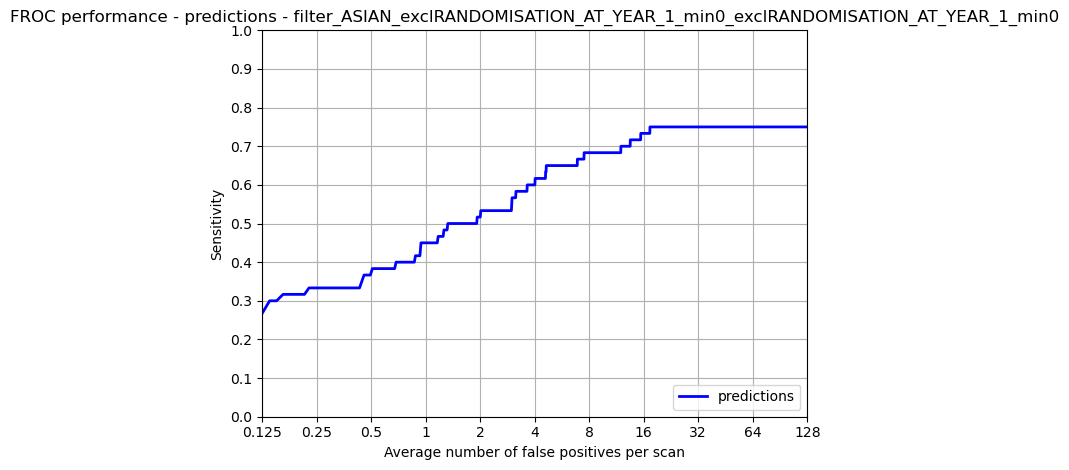

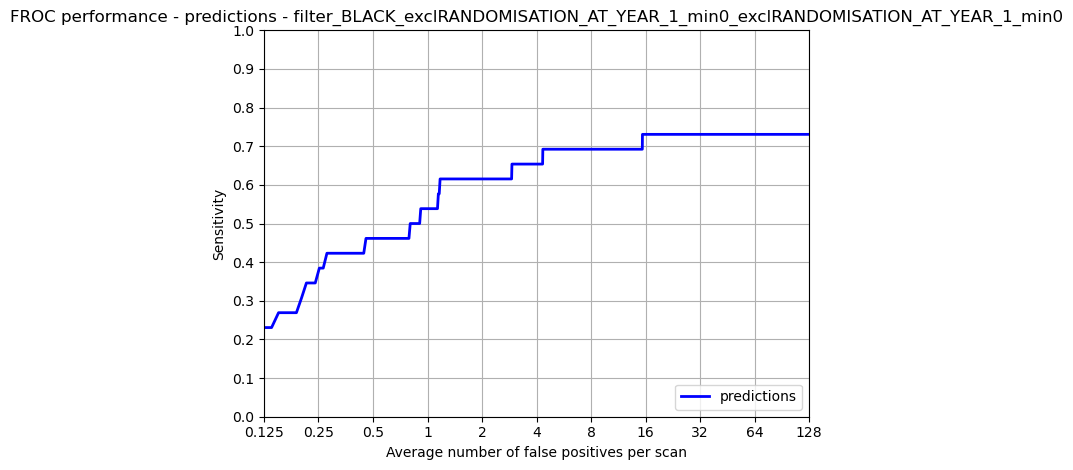

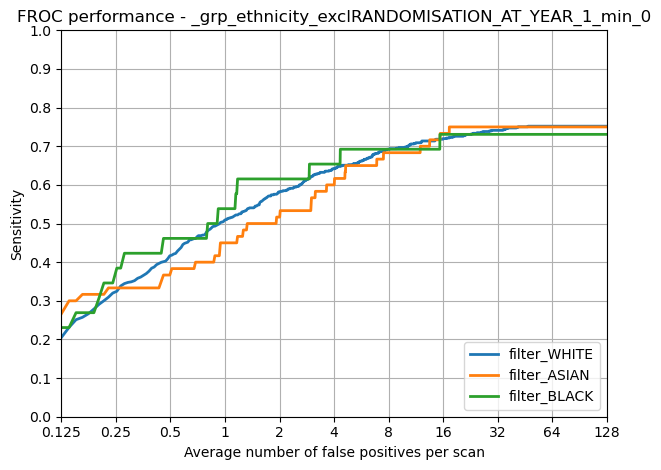

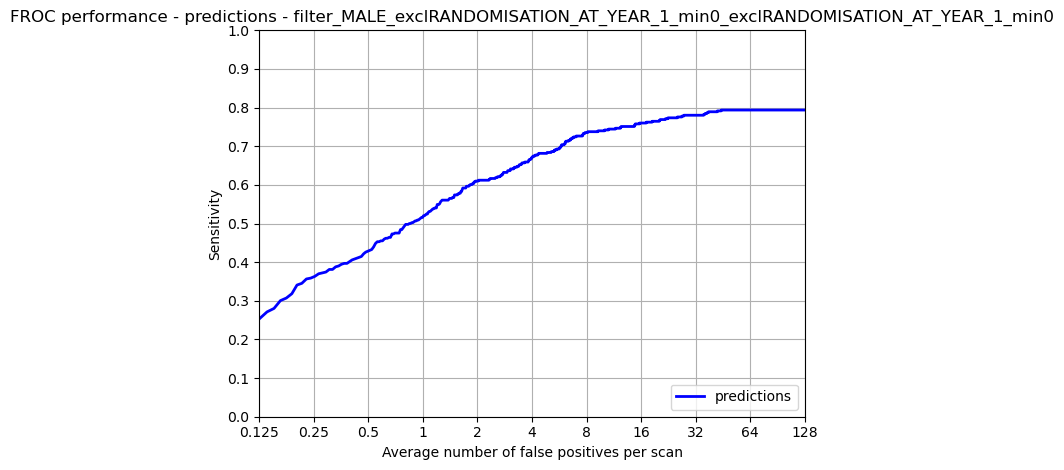

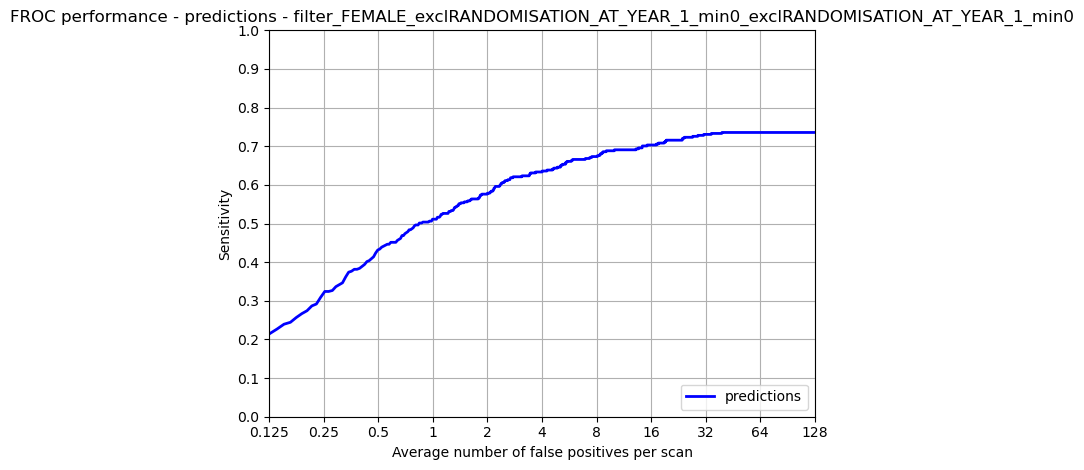

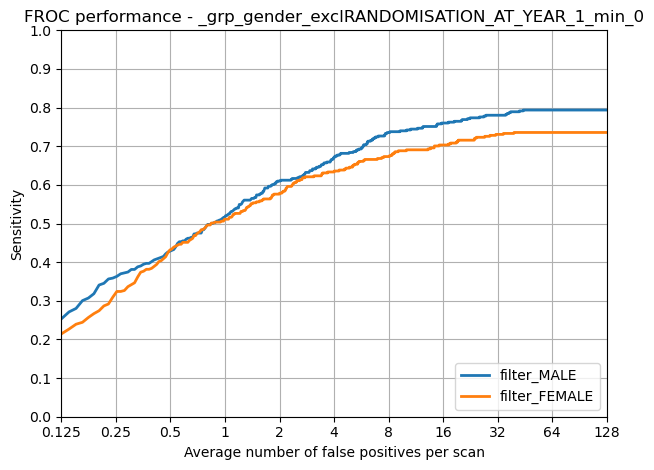

In [ ]:


for management_plan in ['','RANDOMISATION_AT_YEAR_1']:
    for min_nodule_diameter in [0]:
        for filter_group_name, filter_group in filters.items():
            filters_fps_itp = []
            filters_sens_itp = []

            for filter_key, filter_settings in filter_group.items():

                filter_name = filter_key+f'_excl{management_plan}_min{min_nodule_diameter}'
                output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
                output_dir.mkdir(parents=True, exist_ok=True)
                fps_itp, sens_itp = FROCScores(scan_metadata,
                        nodule_metadata,
                        predictions,
                        output_dir,
                        filter_name+f'_excl{management_plan}_min{min_nodule_diameter}',
                        min_nodule_diameter,
                        management_plan,
                        filter_settings['ethnicity'],
                        filter_settings['gender'],
                        filter_settings['age'],
                        10000)
                
                filters_fps_itp.append(fps_itp)
                filters_sens_itp.append(sens_itp)

                _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)                

            create_summary_froc_graph(
                output_path=Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME),
                limiter=f'_grp_{filter_group_name}_excl{management_plan}_min_{min_nodule_diameter}',
                filter_names=list(filter_group.keys()),
                filters_fps_itp=filters_fps_itp,
                filters_sens_itp=filters_sens_itp)
            

In [ ]:
# check the misses




def get_missed_image_details(output_path):

    misses = (
                pd.read_csv(Path(output_path, 'results', 'nodulesWithoutCandidate_predictions.txt'), header=None)
                .rename(columns={
                    0:'name',
                    1:'idx',
                    2:'col',
                    3:'row',
                    4:'index',
                    5:'diameter',
                    6:'candidate_idx'}
                )
    )

    nodule_data = pd.read_csv(Path(output_path, 'nodule_annotations.csv'))

    misses = misses.merge(nodule_data, left_on='idx', right_on='id', suffixes=['_miss', ''])

    return [
        (
            missed_nodule['name'],
            Ircd(
                index=int(missed_nodule['index']),
                row=int(missed_nodule['row']),
                col=int(missed_nodule['col']),
                diameter=int(missed_nodule['diameter'])
            ),
            missed_nodule['nodule_type'])
        for idx, missed_nodule in misses.iterrows()
    ]

miss_check(Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, 'filter_None'), nodule_metadata, 'RANDOMISATION_AT_YEAR_1')

for management_plan in ['','RANDOMISATION_AT_YEAR_1']:
    for min_nodule_diameter in [0]:
        for filter_group_name, filter_group in filters.items():
            for filter_key, filter_settings in filter_group.items():

                filter_name = filter_key+f'_excl{management_plan}_min{min_nodule_diameter}'
                output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
                output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
                print(output_dir)
                _, _, _ = miss_check(output_dir, combined_nodule_data, management_plan)

'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1236,89,710,82,710,82
Black,76,5,40,4,40,4
Asian or Asian British,44,3,73,8,73,8
Other ethnic groups,24,1,17,1,17,1
Mixed,1,0,22,2,22,2
FEMALE,974,70,408,47,408,47
MALE,407,29,454,52,454,52
65-69,704,50,254,29,254,29
60-64,277,20,188,21,188,21
70-75,242,17,229,26,229,26


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,844,61,179,20,179,20
NON_SOLID,203,14,134,15,134,15
SOLID,177,12,418,48,418,48
PART_SOLID,97,7,107,12,107,12
ENDOBRONCHIAL,60,4,24,2,24,2
3_MONTH_FOLLOW_UP_SCAN,1176,85,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,203,14,134,15,134,15
URGENT_REFERRAL,2,0,67,7,67,7
RIGHT_UPPER_LOBE,386,27,280,32,280,32
LEFT_UPPER_LOBE,375,27,173,20,173,20


,misses (%),sample (%),all (%)
count,1381.000000,862.000000,862.000000
mean,3.799126,11.030278,11.030278
std,2.982668,6.261209,6.261209
min,0.000000,0.000000,0.000000
25%,1.940040,7.400000,7.400000
50%,3.514649,9.050000,9.050000
75%,4.935938,13.100000,13.100000
max,29.139242,41.100000,41.100000


../output/results/GRT123/trained_summit/all/filter_WHITE_excl_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,6120.0,100.0,2264.0,100.0,2264,78
Asian or Asian British,0.0,0.0,0.0,0.0,299,10
Black,0.0,0.0,0.0,0.0,172,6
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
FEMALE,3238.0,52.0,1008.0,44.0,1170,40
MALE,2882.0,47.0,1256.0,55.0,1696,59
70-75,1992.0,32.0,641.0,28.0,723,25
65-69,1839.0,30.0,639.0,28.0,818,28
60-64,1514.0,24.0,509.0,22.0,664,23


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,2855.0,46.0,927,40,1200,41
PERIFISSURAL,2176.0,35.0,958,42,1211,42
CALCIFIED,781.0,12.0,153,6,179,6
NON_SOLID,168.0,2.0,109,4,145,5
PART_SOLID,85.0,1.0,95,4,107,3
ENDOBRONCHIAL,55.0,0.0,22,0,24,0
RANDOMISATION_AT_YEAR_1,4884.0,79.0,1554,68,2004,69
3_MONTH_FOLLOW_UP_SCAN,1076.0,17.0,555,24,661,23
ALWAYS_SCAN_AT_YEAR_1,160.0,2.0,105,4,134,4
URGENT_REFERRAL,0.0,0.0,50,2,67,2


,misses (%),sample (%),all (%)
count,6120.000000,2264.000000,2866.000000
mean,3.182131,7.288207,7.174110
std,1.565853,4.671423,4.579834
min,0.000000,0.000000,0.000000
25%,2.410353,4.600000,4.500000
50%,2.968750,6.100000,6.000000
75%,3.591990,8.400000,8.200000
max,29.139242,41.100000,41.100000


../output/results/GRT123/trained_summit/all/filter_ASIAN_excl_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Asian or Asian British,2561.0,100.0,299.0,100.0,299,10
White,0.0,0.0,0.0,0.0,2264,78
Black,0.0,0.0,0.0,0.0,172,6
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
MALE,2530.0,98.0,275.0,91.0,1696,59
FEMALE,31.0,1.0,24.0,8.0,1170,40
55-59,2207.0,86.0,104.0,34.0,502,17
65-69,191.0,7.0,85.0,28.0,818,28
60-64,92.0,3.0,62.0,20.0,664,23


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,1937,75,157,52,1200,41
PERIFISSURAL,588,22,111,37,1211,42
NON_SOLID,16,0,15,5,145,5
CALCIFIED,12,0,9,3,179,6
PART_SOLID,7,0,6,2,107,3
ENDOBRONCHIAL,1,0,1,0,24,0
RANDOMISATION_AT_YEAR_1,2517,98,226,75,2004,69
3_MONTH_FOLLOW_UP_SCAN,32,1,50,16,661,23
ALWAYS_SCAN_AT_YEAR_1,10,0,13,4,134,4
URGENT_REFERRAL,2,0,10,3,67,2


,misses (%),sample (%),all (%)
count,2561.000000,299.000000,2866.000000
mean,2.738144,6.795987,7.174110
std,0.740106,4.341873,4.579834
min,0.000000,0.000000,0.000000
25%,2.313281,4.400000,4.500000
50%,2.570312,5.500000,6.000000
75%,3.020117,7.600000,8.200000
max,11.588678,28.200000,41.100000


../output/results/GRT123/trained_summit/all/filter_BLACK_excl_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Black,698.0,100.0,172.0,100.0,172,6
White,0.0,0.0,0.0,0.0,2264,78
Asian or Asian British,0.0,0.0,0.0,0.0,299,10
Other ethnic groups,0.0,0.0,0.0,0.0,74,2
Mixed,0.0,0.0,0.0,0.0,57,1
FEMALE,429.0,61.0,91.0,52.0,1170,40
MALE,269.0,38.0,81.0,47.0,1696,59
65-69,313.0,44.0,54.0,31.0,818,28
60-64,207.0,29.0,51.0,29.0,664,23
55-59,131.0,18.0,39.0,22.0,502,17


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,402.0,57.0,91.0,52.0,1211,42
SOLID,225.0,32.0,63.0,36.0,1200,41
CALCIFIED,40.0,5.0,10.0,5.0,179,6
NON_SOLID,29.0,4.0,6.0,3.0,145,5
PART_SOLID,2.0,0.0,2.0,1.0,107,3
ENDOBRONCHIAL,0.0,0.0,0.0,0.0,24,0
RANDOMISATION_AT_YEAR_1,622.0,89.0,132.0,76.0,2004,69
3_MONTH_FOLLOW_UP_SCAN,47.0,6.0,29.0,16.0,661,23
ALWAYS_SCAN_AT_YEAR_1,29.0,4.0,6.0,3.0,134,4
URGENT_REFERRAL,0.0,0.0,5.0,2.0,67,2


,misses (%),sample (%),all (%)
count,698.000000,172.000000,2866.000000
mean,3.282334,6.444186,7.174110
std,1.554994,3.248845,4.579834
min,0.000000,0.000000,0.000000
25%,2.645506,4.300000,4.500000
50%,3.093750,5.500000,6.000000
75%,3.645704,7.600000,8.200000
max,12.272264,20.000000,41.100000


../output/results/GRT123/trained_summit/all/filter_MALE_excl_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,2882.0,49.0,1256.0,74.0,2264,78
Asian or Asian British,2530.0,43.0,275.0,16.0,299,10
Black,269.0,4.0,81.0,4.0,172,6
Other ethnic groups,95.0,1.0,57.0,3.0,74,2
Mixed,23.0,0.0,27.0,1.0,57,1
MALE,5799.0,100.0,1696.0,100.0,1696,59
FEMALE,0.0,0.0,0.0,0.0,1170,40
55-59,2672.0,46.0,334.0,19.0,502,17
70-75,1398.0,24.0,455.0,26.0,723,25
65-69,1107.0,19.0,518.0,30.0,818,28


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,3404,58,729,42,1200,41
PERIFISSURAL,2056,35,763,44,1211,42
CALCIFIED,182,3,78,4,179,6
NON_SOLID,116,2,65,3,145,5
PART_SOLID,26,0,52,3,107,3
ENDOBRONCHIAL,15,0,9,0,24,0
RANDOMISATION_AT_YEAR_1,5392,92,1242,73,2004,69
3_MONTH_FOLLOW_UP_SCAN,297,5,358,21,661,23
ALWAYS_SCAN_AT_YEAR_1,108,1,62,3,134,4
URGENT_REFERRAL,2,0,34,2,67,2


,misses (%),sample (%),all (%)
count,5799.000000,1696.000000,2866.000000
mean,3.109921,7.136085,7.174110
std,1.363787,4.514977,4.579834
min,0.000000,0.000000,0.000000
25%,2.506054,4.500000,4.500000
50%,2.867188,6.000000,6.000000
75%,3.469921,8.100000,8.200000
max,29.139242,41.100000,41.100000


../output/results/GRT123/trained_summit/all/filter_FEMALE_excl_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,3238.0,84.0,1008.0,86.0,2264,78
Black,429.0,11.0,91.0,7.0,172,6
Mixed,68.0,1.0,30.0,2.0,57,1
Other ethnic groups,46.0,1.0,17.0,1.0,74,2
Asian or Asian British,31.0,0.0,24.0,2.0,299,10
FEMALE,3812.0,100.0,1170.0,100.0,1170,40
MALE,0.0,0.0,0.0,0.0,1696,59
60-64,1405.0,36.0,364.0,31.0,664,23
65-69,1272.0,33.0,300.0,25.0,818,28
70-75,718.0,18.0,268.0,22.0,723,25


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,1705.0,44.0,471,40,1200,41
PERIFISSURAL,1209.0,31.0,448,38,1211,42
CALCIFIED,662.0,17.0,101,8,179,6
NON_SOLID,120.0,3.0,80,6,145,5
PART_SOLID,71.0,1.0,55,4,107,3
ENDOBRONCHIAL,45.0,1.0,15,1,24,0
RANDOMISATION_AT_YEAR_1,2838.0,74.0,762,65,2004,69
3_MONTH_FOLLOW_UP_SCAN,879.0,23.0,303,25,661,23
ALWAYS_SCAN_AT_YEAR_1,95.0,2.0,72,6,134,4
URGENT_REFERRAL,0.0,0.0,33,2,67,2


,misses (%),sample (%),all (%)
count,3812.000000,1170.000000,2866.000000
mean,2.992094,7.229231,7.174110
std,1.447589,4.673645,4.579834
min,0.000000,0.000000,0.000000
25%,2.305860,4.500000,4.500000
50%,2.851952,6.000000,6.000000
75%,3.468557,8.300000,8.200000
max,20.614079,36.700000,41.100000


../output/results/GRT123/trained_summit/all/filter_WHITE_exclRANDOMISATION_AT_YEAR_1_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1236.0,100.0,710.0,100.0,710,82
Asian or Asian British,0.0,0.0,0.0,0.0,73,8
Black,0.0,0.0,0.0,0.0,40,4
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
FEMALE,916.0,74.0,367.0,51.0,408,47
MALE,320.0,25.0,343.0,48.0,454,52
65-69,670.0,54.0,204.0,28.0,254,29
60-64,230.0,18.0,151.0,21.0,188,21
70-75,228.0,18.0,209.0,29.0,229,26


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,781.0,63.0,153,21,179,20
NON_SOLID,160.0,12.0,105,14,134,15
SOLID,155.0,12.0,335,47,418,48
PART_SOLID,85.0,6.0,95,13,107,12
ENDOBRONCHIAL,55.0,4.0,22,3,24,2
3_MONTH_FOLLOW_UP_SCAN,1076.0,87.0,555,78,661,76
ALWAYS_SCAN_AT_YEAR_1,160.0,12.0,105,14,134,15
URGENT_REFERRAL,0.0,0.0,50,7,67,7
RIGHT_UPPER_LOBE,331.0,26.0,233,32,280,32
LEFT_UPPER_LOBE,321.0,25.0,145,20,173,20


,misses (%),sample (%),all (%)
count,1236.000000,710.000000,862.000000
mean,3.758512,11.025915,11.030278
std,2.935617,6.326986,6.261209
min,0.000000,0.000000,0.000000
25%,1.940040,7.300000,7.400000
50%,3.468557,9.100000,9.050000
75%,4.921875,12.900000,13.100000
max,29.139242,41.100000,41.100000


../output/results/GRT123/trained_summit/all/filter_ASIAN_exclRANDOMISATION_AT_YEAR_1_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Asian or Asian British,44.0,100.0,73.0,100.0,73,8
White,0.0,0.0,0.0,0.0,710,82
Black,0.0,0.0,0.0,0.0,40,4
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
MALE,35.0,79.0,67.0,91.0,454,52
FEMALE,9.0,20.0,6.0,8.0,408,47
65-69,15.0,34.0,25.0,34.0,254,29
75+,10.0,22.0,6.0,8.0,66,7
70-75,8.0,18.0,11.0,15.0,229,26


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,14,31,44,60,418,48
CALCIFIED,12,27,9,12,179,20
NON_SOLID,10,22,13,17,134,15
PART_SOLID,7,15,6,8,107,12
ENDOBRONCHIAL,1,2,1,1,24,2
3_MONTH_FOLLOW_UP_SCAN,32,72,50,68,661,76
ALWAYS_SCAN_AT_YEAR_1,10,22,13,17,134,15
URGENT_REFERRAL,2,4,10,13,67,7
RIGHT_UPPER_LOBE,21,47,26,35,280,32
NOT_ANSWERED,7,15,6,8,84,9


,misses (%),sample (%),all (%)
count,44.000000,73.000000,862.000000
mean,4.707214,11.420548,11.030278
std,2.733387,6.348796,6.261209
min,0.000000,0.000000,0.000000
25%,3.354641,7.500000,7.400000
50%,4.763673,9.000000,9.050000
75%,5.996875,13.200000,13.100000
max,11.588678,28.200000,41.100000


../output/results/GRT123/trained_summit/all/filter_BLACK_exclRANDOMISATION_AT_YEAR_1_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
Black,76.0,100.0,40.0,100.0,40,4
White,0.0,0.0,0.0,0.0,710,82
Asian or Asian British,0.0,0.0,0.0,0.0,73,8
Mixed,0.0,0.0,0.0,0.0,22,2
Other ethnic groups,0.0,0.0,0.0,0.0,17,1
MALE,42.0,55.0,20.0,50.0,454,52
FEMALE,34.0,44.0,20.0,50.0,408,47
60-64,31.0,40.0,12.0,30.0,188,21
55-59,19.0,25.0,12.0,30.0,125,14
65-69,13.0,17.0,9.0,22.0,254,29


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,40.0,52.0,10.0,25.0,179,20
NON_SOLID,29.0,38.0,6.0,15.0,134,15
SOLID,5.0,6.0,22.0,55.0,418,48
PART_SOLID,2.0,2.0,2.0,5.0,107,12
ENDOBRONCHIAL,0.0,0.0,0.0,0.0,24,2
3_MONTH_FOLLOW_UP_SCAN,47.0,61.0,29.0,72.0,661,76
ALWAYS_SCAN_AT_YEAR_1,29.0,38.0,6.0,15.0,134,15
URGENT_REFERRAL,0.0,0.0,5.0,12.0,67,7
LEFT_UPPER_LOBE,45.0,59.0,8.0,20.0,173,20
RIGHT_UPPER_LOBE,20.0,26.0,10.0,25.0,280,32


,misses (%),sample (%),all (%)
count,76.000000,40.000000,862.000000
mean,4.225088,10.162500,11.030278
std,3.862974,4.299653,6.261209
min,0.000000,0.000000,0.000000
25%,0.000000,7.600000,7.400000
50%,3.494534,8.900000,9.050000
75%,7.930080,12.500000,13.100000
max,12.272264,20.000000,41.100000


../output/results/GRT123/trained_summit/all/filter_MALE_exclRANDOMISATION_AT_YEAR_1_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,320.0,78.0,343.0,75.0,710,82
Black,42.0,10.0,20.0,4.0,40,4
Asian or Asian British,35.0,8.0,67.0,14.0,73,8
Other ethnic groups,10.0,2.0,11.0,2.0,17,1
Mixed,0.0,0.0,13.0,2.0,22,2
MALE,407.0,100.0,454.0,100.0,454,52
FEMALE,0.0,0.0,0.0,0.0,408,47
70-75,179.0,43.0,141.0,31.0,229,26
65-69,120.0,29.0,136.0,29.0,254,29
55-59,57.0,14.0,80.0,17.0,125,14


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,182,44,78,17,179,20
NON_SOLID,108,26,62,13,134,15
SOLID,76,18,253,55,418,48
PART_SOLID,26,6,52,11,107,12
ENDOBRONCHIAL,15,3,9,1,24,2
3_MONTH_FOLLOW_UP_SCAN,297,72,358,78,661,76
ALWAYS_SCAN_AT_YEAR_1,108,26,62,13,134,15
URGENT_REFERRAL,2,0,34,7,67,7
LEFT_LOWER_LOBE,123,30,71,15,119,13
RIGHT_UPPER_LOBE,85,20,140,30,280,32


,misses (%),sample (%),all (%)
count,407.000000,454.000000,862.000000
mean,5.273333,11.290969,11.030278
std,3.495826,6.384576,6.261209
min,0.000000,0.000000,0.000000
25%,3.445311,7.400000,7.400000
50%,4.862502,9.100000,9.050000
75%,6.106445,13.000000,13.100000
max,29.139242,41.100000,41.100000


../output/results/GRT123/trained_summit/all/filter_FEMALE_exclRANDOMISATION_AT_YEAR_1_min0


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,916.0,94.0,367.0,89.0,710,82
Black,34.0,3.0,20.0,4.0,40,4
Other ethnic groups,14.0,1.0,6.0,1.0,17,1
Asian or Asian British,9.0,0.0,6.0,1.0,73,8
Mixed,1.0,0.0,9.0,2.0,22,2
FEMALE,974.0,100.0,408.0,100.0,408,47
MALE,0.0,0.0,0.0,0.0,454,52
65-69,584.0,59.0,118.0,28.0,254,29
60-64,251.0,25.0,118.0,28.0,188,21
70-75,63.0,6.0,88.0,21.0,229,26


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,662.0,67.0,101,24,179,20
SOLID,101.0,10.0,165,40,418,48
NON_SOLID,95.0,9.0,72,17,134,15
PART_SOLID,71.0,7.0,55,13,107,12
ENDOBRONCHIAL,45.0,4.0,15,3,24,2
3_MONTH_FOLLOW_UP_SCAN,879.0,90.0,303,74,661,76
ALWAYS_SCAN_AT_YEAR_1,95.0,9.0,72,17,134,15
URGENT_REFERRAL,0.0,0.0,33,8,67,7
LEFT_UPPER_LOBE,302.0,31.0,84,20,173,20
RIGHT_UPPER_LOBE,301.0,30.0,140,34,280,32


,misses (%),sample (%),all (%)
count,974.000000,408.000000,862.000000
mean,3.183107,10.740196,11.030278
std,2.495859,6.115759,6.261209
min,0.000000,0.000000,0.000000
25%,1.646095,7.300000,7.400000
50%,3.016407,9.000000,9.050000
75%,4.524610,13.125000,13.100000
max,20.614079,36.700000,41.100000


# Detection Evaluation

## Trained on LUNA16 Evaluated on SUMMIT 

In [ ]:
"""
    The evaluation script accepts 4 parameters

    1. annotations_filename: csv file with following headers:
        - threshold
        - index
        - row
        - col
        - diameter
        - nodule_type
        - brock_score
        - management_plan

    NOTE: Additional nodule fields will need to be added in eval script, fields are hard-coded
    into a nodule class

    2. annotations_excluded_filename: csv containing non-actionable or benign lesions,
    headers as per annotations_filename

    3. seriesuids_filename: single column csv file holding just the scan identifiers

    4. results_filename: csv containing the candidates generated from the detection algorithm.
    Headers as follows:
        - threshold
        - index
        - row
        - col
        - diameter

    5. outputdir: folder to output results to

"""
MODEL_RESULTS_PATH = "/Users/john/Projects/SOTAEvaluationNoduleDetection/models/summit_detection/result"
RESULTS_PATH = '/Users/john/Projects/SOTAEvaluationNoduleDetection/output/results/detect'
METADATA_PATH = '../output/metadata'
TRAINING_DATA = 'trained_luna'
MODEL = 'detect'
NAME = 'all'
PHASE = 'validation'


scan_metadata = (
    pd.read_csv('/Users/john/Projects/SOTAEvaluationNoduleDetection/output/metadata/all/validation_scans_metadata.csv',
                usecols=[
                    'LDCT_RADIOLOGY_REPORT_main_participant_id',
                    'participant_details_gender',
                    'participant_age_at_consent_cats',
                    'mpi_ParticipantMetadata_EthnicCategoryStr'
                ]).rename(columns={
                    'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
                    'participant_details_gender' : 'gender',
                    'participant_age_at_consent_cats' : 'age_group',
                    'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'                    
                })
    .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
)
display(scan_metadata.head())


nodule_metadata = (
    pd.read_csv(Path(METADATA_PATH, NAME, PHASE + "_metadata.csv"))
    .rename(
    columns={
        'index' : 'id',
        'nodule_x_coordinate' : 'col',
        'nodule_y_coordinate' : 'row',
        'nodule_z_coordinate' : 'index',
        'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
        'participant_details_gender' : 'gender',
        'participant_age_at_consent_cats' : 'age_group',
        'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'          
    })
    .assign(name=lambda df: df.main_participant_id + '_Y0_BASELINE_A')
    .assign(threshold=MIN_THRESHOLD)
    .assign(diameter=lambda df: df.nodule_diameter_mm)
)

"""
Deconstruct the json output into the correct format of

    threshold
    index -> z
    row -> y
    col -> x
    diameter
    name -> scan_id
"""
import json
with open(Path(MODEL_RESULTS_PATH, TRAINING_DATA, NAME, 'result_summit_fold0.json'),'r') as f:
    fold0_json = json.load(f)

predictions_dict = {}
idx = 0
for image in fold0_json['validation']:
    name = image['image'].split('/')[-1].split('.',1)[0]
    
    for box, score in zip(image['box'], image['score']):
        prediction = {}
        prediction['threshold'] = score
        prediction['index'] = box[2]
        prediction['row'] = box[1]
        prediction['col'] = box[0]
        prediction['diameter'] = np.max(box[3:])
        prediction['name'] = name

        predictions_dict[idx] = prediction
        idx+=1

predictions = pd.DataFrame.from_dict(predictions_dict,orient='index')

print('Prediction:{}, Nodules:{}, Scans:{}'.format(
    predictions.shape[0],
    nodule_metadata.shape[0],
    scan_metadata.shape[0]
))

,participant_id,gender,age_group,ethnic_group,scan_id
0,summit-2224-gak,MALE,65-69,Black,summit-2224-gak_Y0_BASELINE_A
1,summit-2224-jcz,FEMALE,55-59,Black,summit-2224-jcz_Y0_BASELINE_A
2,summit-2224-jgv,FEMALE,65-69,Asian or Asian British,summit-2224-jgv_Y0_BASELINE_A
3,summit-2225-fhj,FEMALE,70-75,White,summit-2225-fhj_Y0_BASELINE_A
4,summit-2225-stn,MALE,60-64,White,summit-2225-stn_Y0_BASELINE_A


Prediction:12962, Nodules:2868, Scans:1783


In [ ]:

display(nodule_metadata.management_plan.value_counts(dropna=False))
display(
    pd.concat([
        scan_metadata.ethnic_group.value_counts().rename('scans'),
        nodule_metadata.ethnic_group.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.gender.value_counts().rename('scans'),
        nodule_metadata.gender.value_counts().rename('nodules')
    ], axis=1)
)
display(
    pd.concat([
        scan_metadata.age_group.value_counts().rename('scans'),
        nodule_metadata.age_group.value_counts().rename('nodules')
    ], axis=1)
)



RANDOMISATION_AT_YEAR_1    2005
3_MONTH_FOLLOW_UP_SCAN      661
ALWAYS_SCAN_AT_YEAR_1       134
URGENT_REFERRAL              68
Name: management_plan, dtype: int64

,scans,nodules
White,1311,2266.0
Asian or Asian British,205,299.0
Black,130,172.0
Other ethnic groups,77,74.0
Mixed,31,57.0
Not stated,29,NaN


,scans,nodules
MALE,1075,1696
FEMALE,708,1172


,scans,nodules
60-64,461,664
65-69,448,818
70-75,420,723
55-59,365,504
75+,89,159


In [ ]:
# check overlap of scans between predictions and scanlist
scan_list = scan_metadata.scan_id.unique().tolist()
predictions_list = predictions.name.unique().tolist()
len(scan_list), len(predictions_list), len([scan_id for scan_id in predictions_list if scan_id in scan_list])

(1783, 899, 217)

Unique Scans: 1753
/Users/john/Projects/SOTAEvaluationNoduleDetection/output/results/detect/detect/trained_luna/all/filterNone_excl/nodule_annotations.csv
Total number of included nodule annotations: 2834
Total number of nodule annotations: 2834
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1207001,79,2266,79,2266,79
Asian or Asian British,152569,10,299,10,299,10
Black,79110,5,172,5,172,5
Other ethnic groups,47237,3,74,2,74,2
Mixed,33131,2,57,1,57,1
MALE,907271,59,1696,59,1696,59
FEMALE,611777,40,1172,40,1172,40
65-69,423758,27,818,28,818,28
70-75,385377,25,723,25,723,25
60-64,361757,23,664,23,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,650874,42,1211,42,1211,42
SOLID,644962,42,1202,41,1202,41
CALCIFIED,89392,5,179,6,179,6
NON_SOLID,61346,4,145,5,145,5
PART_SOLID,56373,3,107,3,107,3
ENDOBRONCHIAL,16101,1,24,0,24,0
RANDOMISATION_AT_YEAR_1,1054938,69,2005,69,2005,69
3_MONTH_FOLLOW_UP_SCAN,365069,24,661,23,661,23
ALWAYS_SCAN_AT_YEAR_1,54636,3,134,4,134,4
URGENT_REFERRAL,44405,2,68,2,68,2


,misses (%),sample (%),all (%)
count,1.519048e+06,2868.000000,2868.000000
mean,7.348946e+00,7.189191,7.189191
std,4.777556e+00,4.659970,4.659970
min,0.000000e+00,0.000000,0.000000
25%,4.600000e+00,4.500000,4.500000
50%,6.100000e+00,6.000000,6.000000
75%,8.300000e+00,8.200000,8.200000
max,5.360000e+01,53.600000,53.600000


Unique Scans: 1753
/Users/john/Projects/SOTAEvaluationNoduleDetection/output/results/detect/detect/trained_luna/all/filterNone_exclRANDOMISATION_AT_YEAR_1/nodule_annotations.csv
Total number of included nodule annotations: 848
Total number of nodule annotations: 2834
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,116911,81,711,82,711,82
Asian or Asian British,13375,9,73,8,73,8
Black,5359,3,40,4,40,4
Other ethnic groups,4101,2,17,1,17,1
Mixed,3584,2,22,2,22,2
MALE,80764,56,454,52,454,52
FEMALE,62566,43,409,47,409,47
70-75,41177,28,229,26,229,26
65-69,39427,27,254,29,254,29
60-64,29543,20,188,21,188,21


,misses,misses (%),sample,sample (%),all,all (%)
SOLID,76590,53,419,48,419,48
CALCIFIED,27468,19,179,20,179,20
PART_SOLID,17502,12,107,12,107,12
NON_SOLID,16774,11,134,15,134,15
ENDOBRONCHIAL,4996,3,24,2,24,2
3_MONTH_FOLLOW_UP_SCAN,112780,78,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,16774,11,134,15,134,15
URGENT_REFERRAL,13776,9,68,7,68,7
RIGHT_UPPER_LOBE,48735,34,280,32,280,32
RIGHT_LOWER_LOBE,28509,19,158,18,158,18


,misses (%),sample (%),all (%)
count,143330.000000,863.000000,863.000000
mean,11.457392,11.079606,11.079606
std,6.393327,6.423171,6.423171
min,0.000000,0.000000,0.000000
25%,7.400000,7.400000,7.400000
50%,9.300000,9.100000,9.100000
75%,14.100000,13.100000,13.100000
max,53.600000,53.600000,53.600000


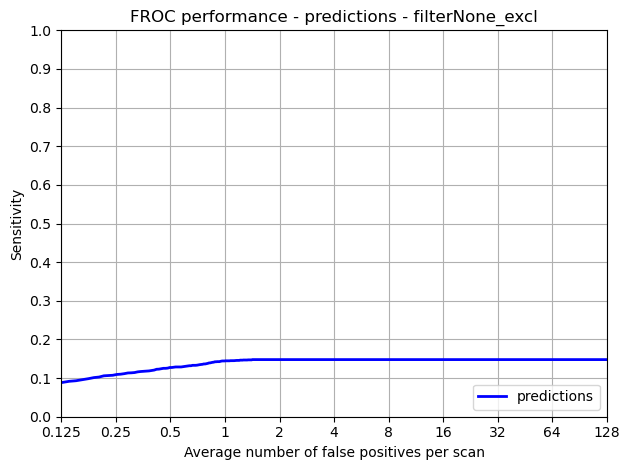

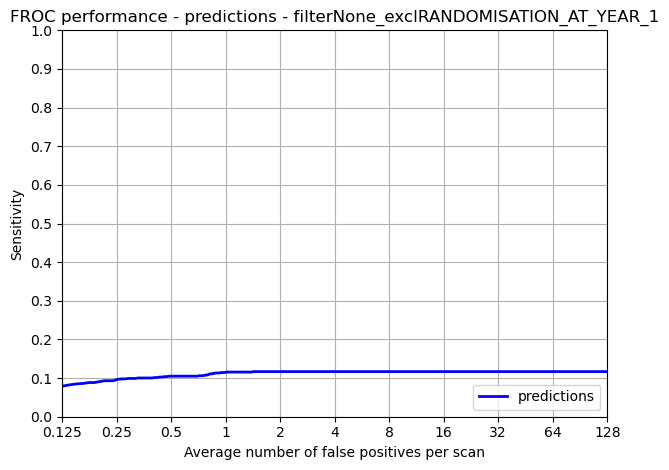

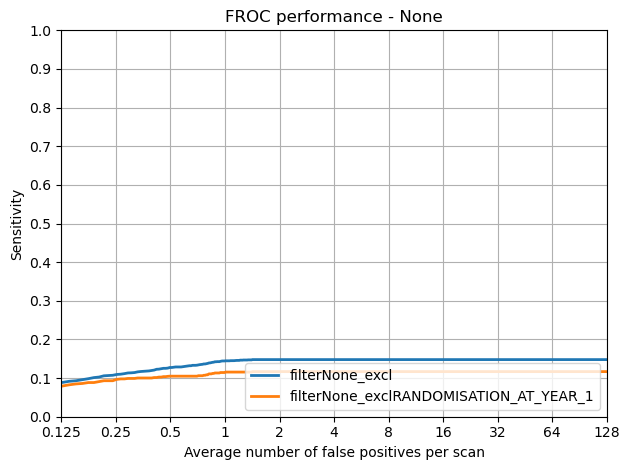

In [ ]:

# What is the overall FROC Score

filter_names = []
filters_fps_itp = []
filters_sens_itp = []

for management_plan in ['', 'RANDOMISATION_AT_YEAR_1']:

    filter_name = 'filterNone_excl'+management_plan
    filter_names.append(filter_name)

    output_dir = Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME, filter_name)
    output_dir.mkdir(parents=True, exist_ok=True)

    fps_itp, sens_itp = FROCScores(scan_metadata,
        nodule_metadata,
        predictions,
        output_dir,
        filter_name,
        0,
        management_plan,
        ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
        ['MALE','FEMALE'],
        ['55-59', '60-64', '65-69', '70-75', '75+'],
        10000)
    
    _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)
    
    filters_fps_itp.append(fps_itp)
    filters_sens_itp.append(sens_itp)


create_summary_froc_graph(
    Path(RESULTS_PATH, MODEL, TRAINING_DATA, NAME),
    None,
    filter_names,
    filters_fps_itp,
    filters_sens_itp
)